In [1]:
import pandas as pd
import glob

import numpy as np

import matplotlib.pyplot as plt

import sys
import csv

csv.field_size_limit(sys.maxsize)

131072

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [46]:
path = '/content/drive/My Drive/UCLA/Course/Homework/CS260C/Final Project/results_v6'
data = pd.concat(map(pd.read_csv, glob.glob(path + "/*.csv")))

In [4]:
## Visualization 1
import regex as re

def get_noise_type(noise_info: str):
    val = noise_info.split(',')[0]
    noise_type = val.split(':')[1]
    noise_type = noise_type.replace("'", '')
    noise_type = noise_type.rstrip()
    noise_type = noise_type.lstrip()
    return noise_type

def get_noise_strategy(noise_info: str):
    val = noise_info.split(',')[1]
    strategy = val.split(':')[1]
    strategy = strategy.replace("'", '')
    strategy = strategy.rstrip()
    strategy = strategy.lstrip()
    return strategy

def get_choose_k(noise_info: str):
    
    try:
        ind = noise_info.rindex("choose_type")
        new_str = noise_info[ind: ]
        val = new_str.split(',')[1]
        choose_k = val.split(':')[1]
        choose_k = choose_k.replace("'", '')
        choose_k = choose_k.rstrip()
        choose_k = choose_k.lstrip()
    except:
        choose_k = "Not_Available"
    return choose_k

def get_noiseLvl1 (x_type: str):
    try:
        ind = x_type.rindex("noise_level")
        new_str = x_type[ind: ]
        val = new_str.split('-')[1]
        val = val.rstrip()
        val = val.lstrip()
    except:
        val = 0
#     print(val)
    return float(val)

def get_noiseLvl1_from_edge (edge_type: str):
    try:
        ind = edge_type.rindex("noise_level")
        new_str = edge_type[ind: ]
        val = new_str.split('-')[1]
        val = val.split('_')[0]
        val = val.rstrip()
        val = val.lstrip()
    except:
        val = 0
#     print(val)
    return float(val)

In [47]:
data['noise_type'] = data['noise_info'].apply(lambda x: get_noise_type(x))
data['noise_strategy'] = data['noise_info'].apply(lambda x: get_noise_strategy(x))
data['choose_k'] = data['noise_info'].apply(lambda x: get_choose_k(x))
data['x_type_noiseLvl'] = data['x_type'].apply(lambda x: get_noiseLvl1(x))
data['edge_type_noiseLvl'] = data['edge_type'].apply(lambda x: get_noiseLvl1_from_edge(x))

## For some reason for the same 'choose_type' there are 3 'choose_k'

data['noise_level'] = data['noise_level'].fillna(data['x_type_noiseLvl'])
data['noise_level'] = data.apply(lambda row: row['edge_type_noiseLvl'] if row['noise_strategy'] == 'all_edges' \
                                else row['noise_level'], axis = 1)


In [48]:
# parameters
noise_levels = [0, 0.01, 0.05, 0.1, 0.15, 0.3, 0.45, 0.6, 0.9, 0.95, 0.99, 1 ]
choose_type = ['random', 'top', 'bottom']
graph_models = ['GNN', 'GAT', 'Graphsage']
noise_type = ['feature_noise', 'edge_removal', 'edge_addition']
strategy_type = ['all_edges', 'nodes'] # for edge_removal and edge addition
# for edge removal - strategy is all edges or nodes
k_nodes = list(set(data[(data['noise_type'] == 'edge_removal') & (data['noise_strategy'] == 'nodes')]['k_nodes']))

In [59]:
def plot_image(noise_lvl, acc, std, models, title, xlabel, ylabel):
    plt.figure(figsize=(12,8))
    for i in range(len(acc)):
        plt.errorbar(noise_lvl[i], acc[i], yerr=std[i], lw=3, label=models[i], fmt='-o', markersize=6, capsize=6, capthick=2, elinewidth=2)
    plt.title(title)
    plt.xlabel(xlabel, fontsize=10)
    plt.ylabel(ylabel, fontsize=10)
    plt.ylim([0, 1])
    plt.grid()
    plt.legend()
    plt.show()

def plot_data_cal(input_data):

    acc = []
    std = []
    noise_lvl = []

    for model in graph_models:
        sub_data = input_data[input_data['model_name'] == model][['noise_level','test_accuracies']]
        sub_data = sub_data.sort_values('noise_level')
        acc_compact = []
        std_compact = []
        nls = sub_data['noise_level']
        acs = sub_data['test_accuracies']

        noise_lvl_compact = [nls.iloc[0]]
        cur_acc = []
    
        for nl, ac in zip(nls, acs):
            if noise_lvl_compact[-1] != nl:
                noise_lvl_compact.append(nl)
                acc_compact.append(np.average(cur_acc))
                std_compact.append(np.std(cur_acc))
                ac = [float(x) for x in ac.split(',')]
                cur_acc = ac
            else:
                ac = [float(x) for x in ac.split(',')]
                cur_acc += ac

        acc_compact.append(np.average(cur_acc))
        std_compact.append(np.std(cur_acc))

        acc.append(acc_compact)
        std.append(std_compact)
        noise_lvl.append(noise_lvl_compact)
    return acc, std, noise_lvl


def plot_comparison(data: pd.DataFrame(), noise_type = 'feature_noise', strategy_type = 'all_edges', \
                   choose_type = 'random', k_nodes=None, bidirectional=False):
    
    if(noise_type == 'feature_noise'):

        input_data = data[data['noise_type'] == noise_type]
        title = 'Plot comparison for noise: ' + noise_type
        
    elif(noise_type in ['edge_removal','edge_addition'] and strategy_type == 'all_edges'):

        input_data = data[(data['noise_type'] == noise_type) & \
                          (data['noise_strategy'] == strategy_type) & \
                          (data['bidirectional'] == bidirectional)]
        title = 'Plot comparison for noise: ' + noise_type + ', stragey is: ' + strategy_type + ', bidirectional is: ' + str(bidirectional)
        
    elif( (noise_type in ['edge_removal','edge_addition']) and (strategy_type == 'nodes') \
       and (choose_type in  ['random', 'top_k', 'bottom_k'])):
      
        k_node = k_nodes.pop(0)
        input_data = data[(data['noise_type'] == noise_type) & \
                   (data['noise_strategy'] == strategy_type) & \
                  (data['choose_type'] == choose_type) & \
                  (data['k_nodes'] == k_node) & \
                  (data['bidirectional'] == bidirectional)]
        title = 'Plot comparison for noise: ' + noise_type + ', stragey is: ' + strategy_type \
                     + ', choose_type is ' + choose_type + ', for k = ' + str(k_node) + ', bidirectional is: ' + str(bidirectional)

    else:
        raise Exception("Wrong input data!")

    acc, std, noise_lvl = plot_data_cal(input_data)
    plot_image(noise_lvl, acc, std, graph_models, title, 'noise_lvl', 'test_acc')

    if k_nodes:
      plot_comparison(data, noise_type, strategy_type, choose_type, k_nodes, bidirectional)

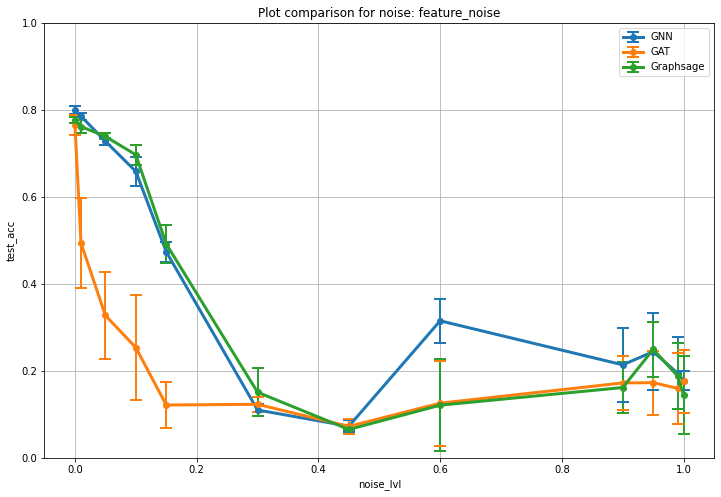

In [60]:
plot_comparison(data, 'feature_noise')

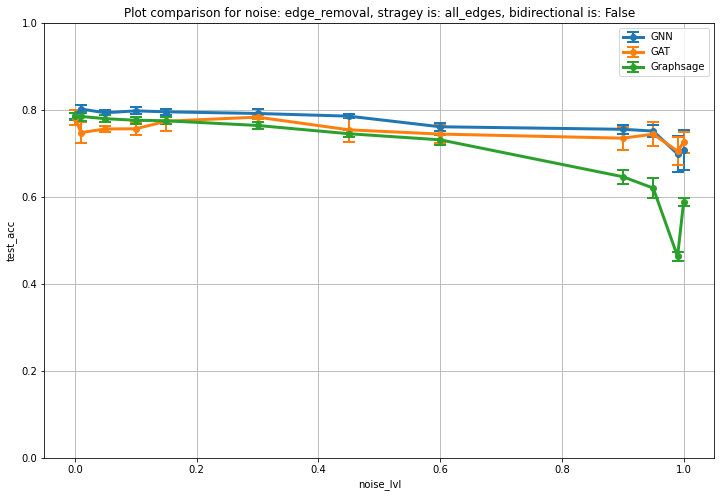

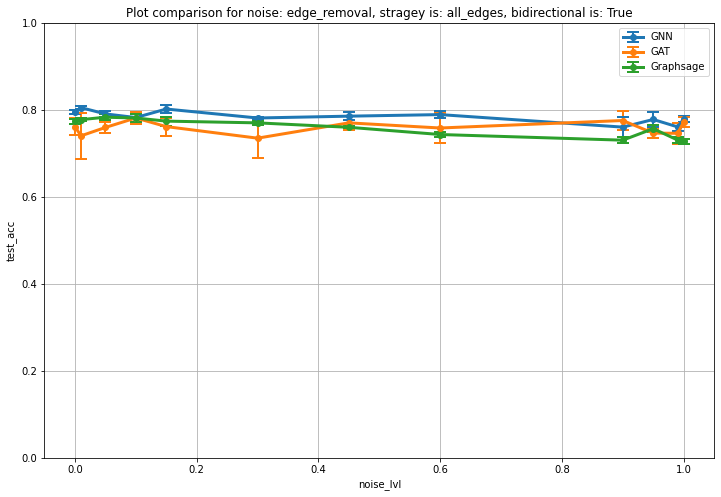

In [61]:
plot_comparison(data, 'edge_removal', 'all_edges', bidirectional=False)
plot_comparison(data, 'edge_removal', 'all_edges', bidirectional=True)

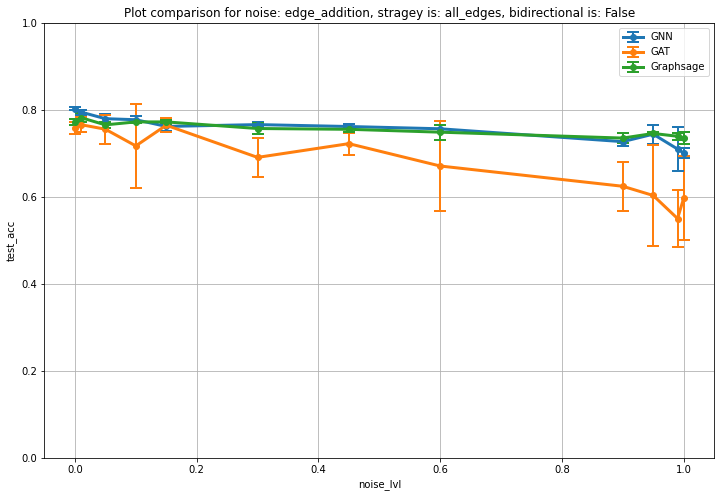

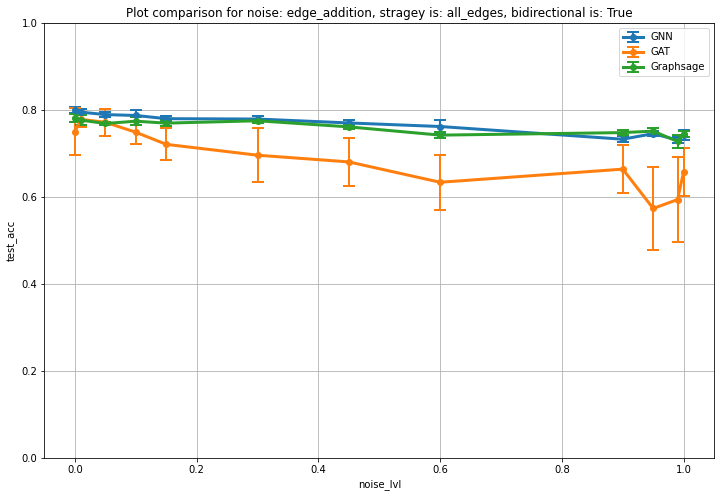

In [62]:
plot_comparison(data, 'edge_addition', 'all_edges', bidirectional=False)
plot_comparison(data, 'edge_addition', 'all_edges', bidirectional=True)

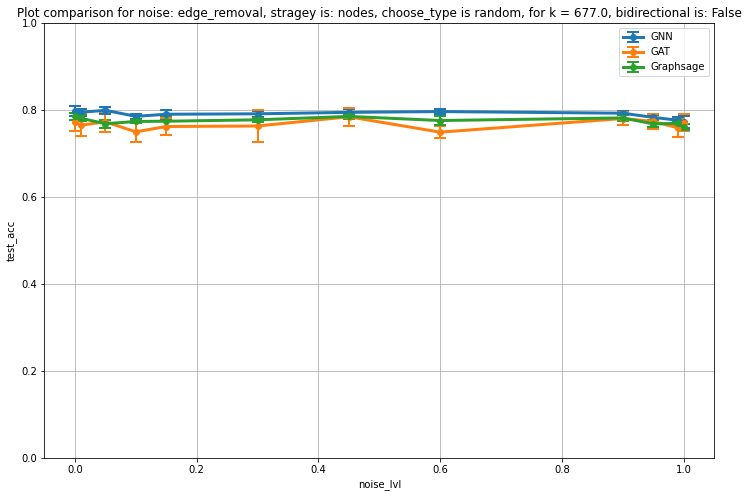

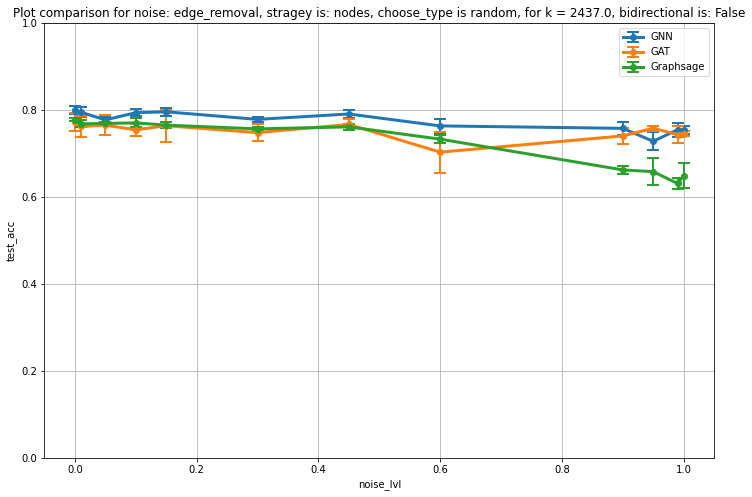

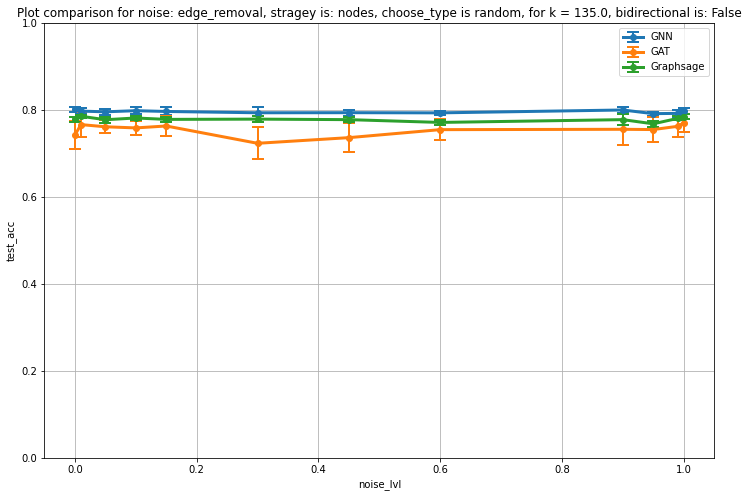

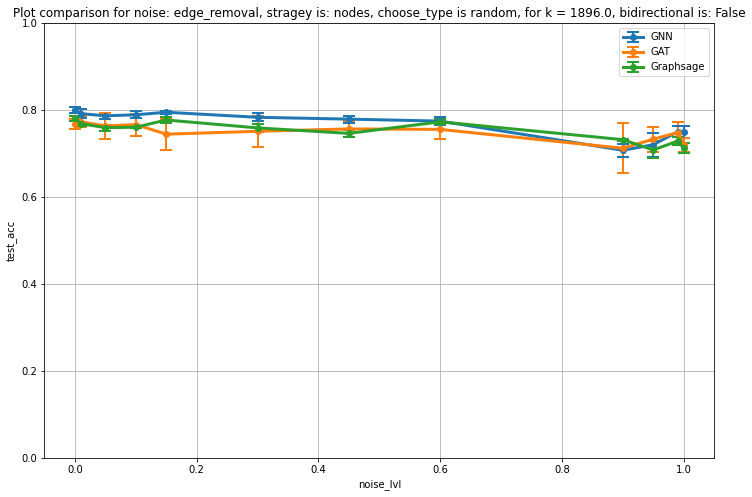

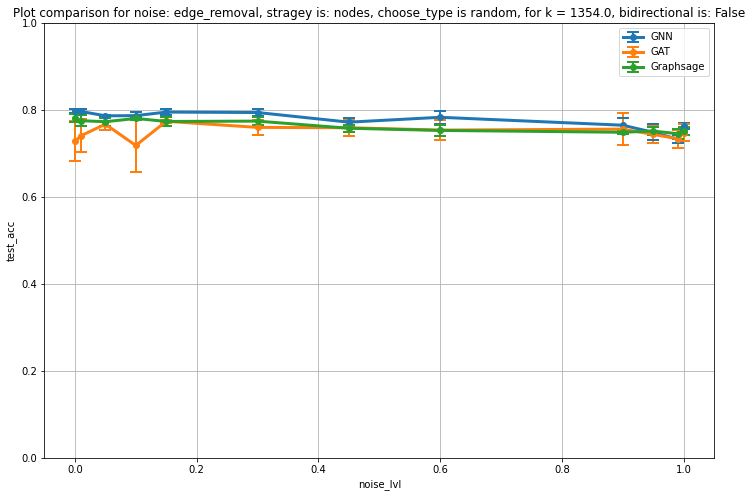

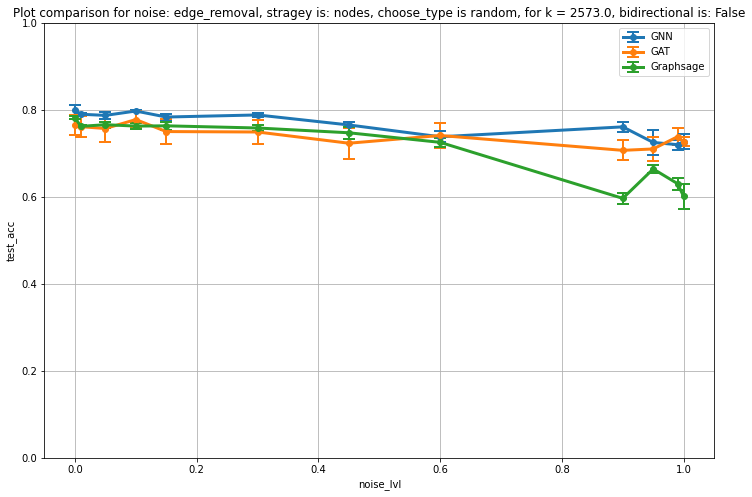

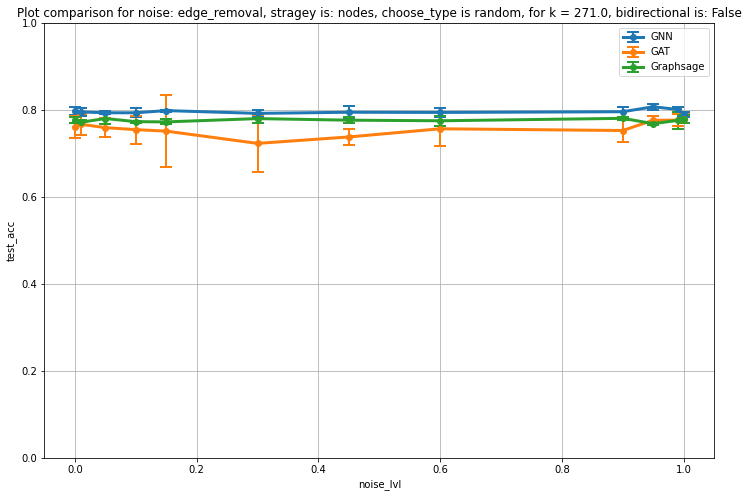

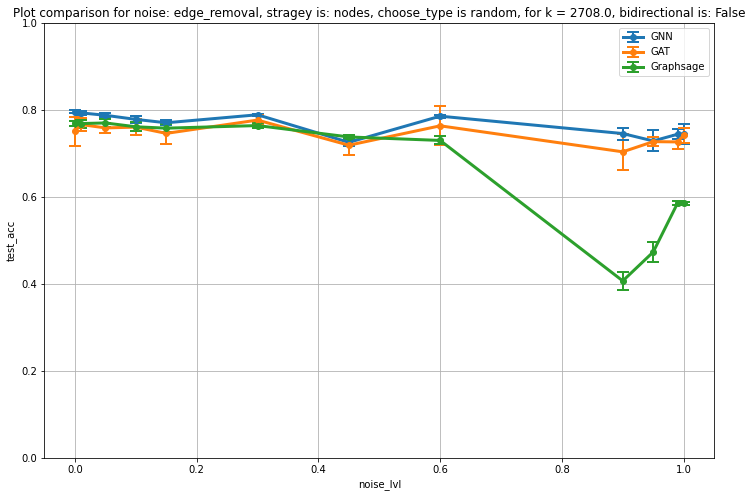

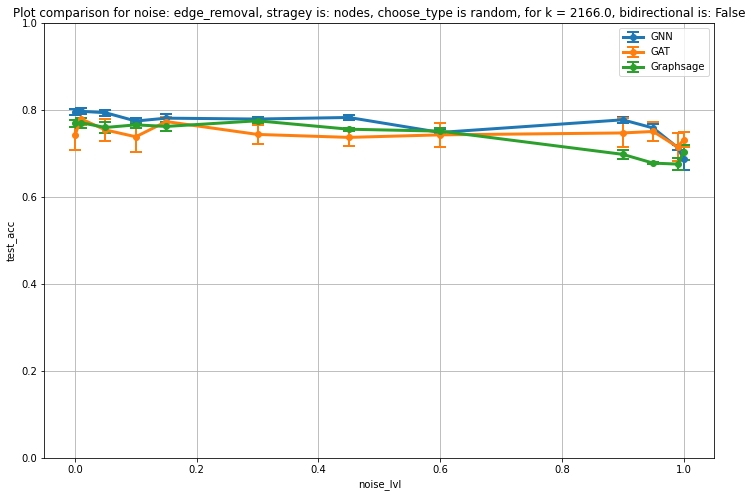

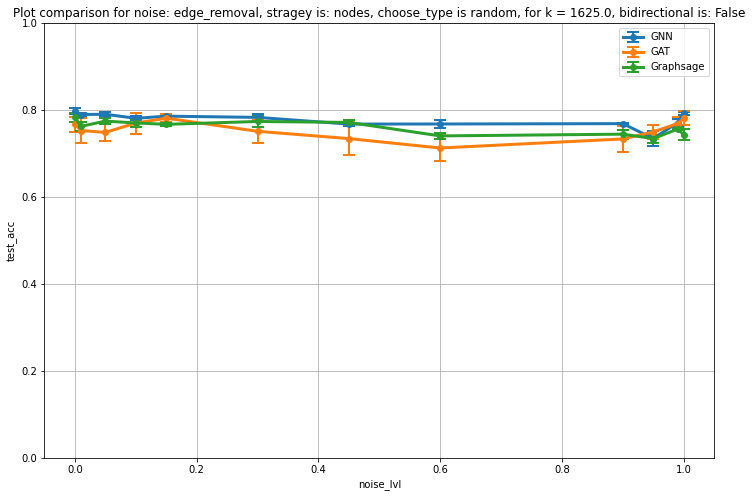

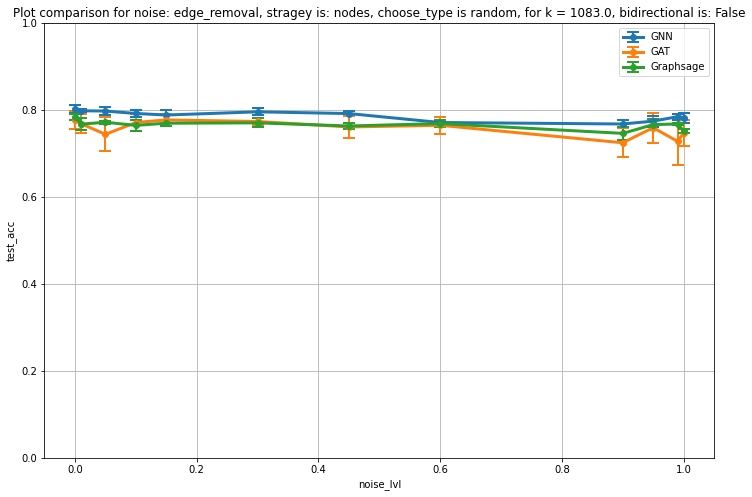

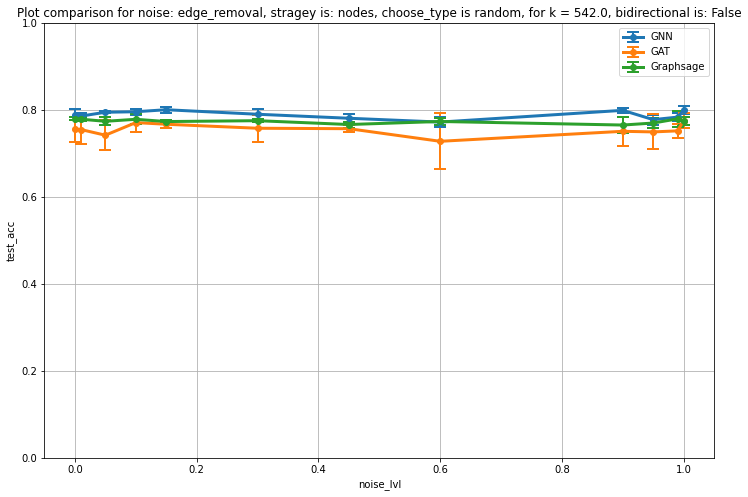

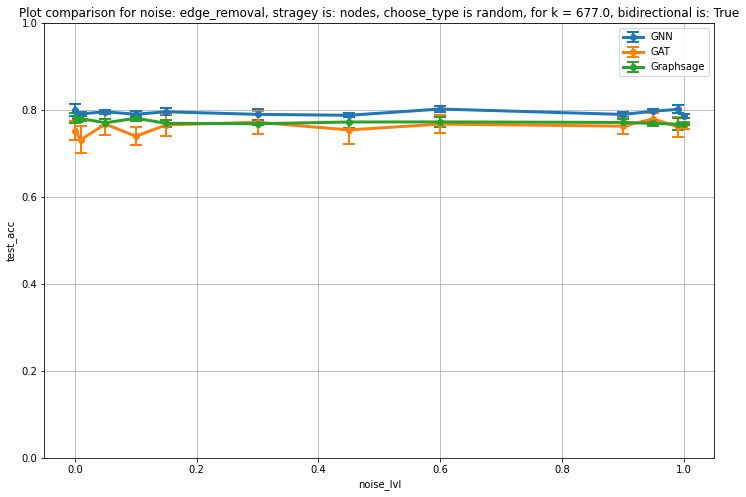

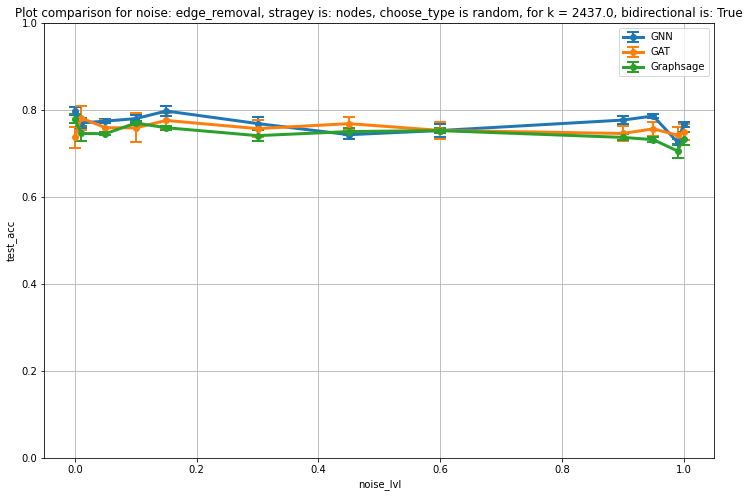

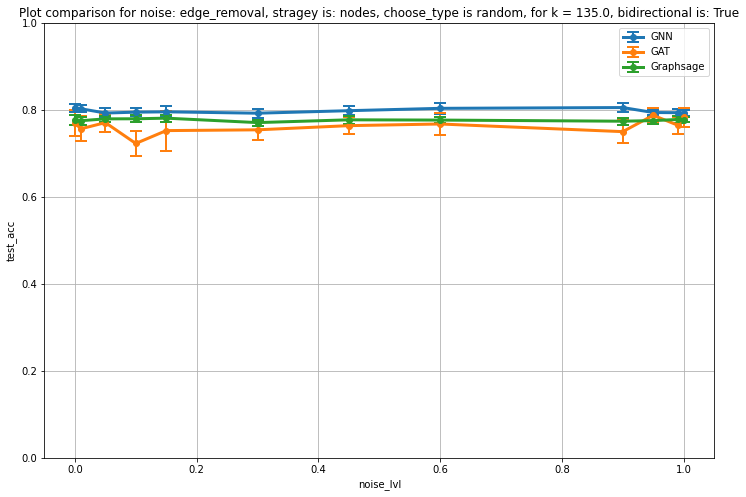

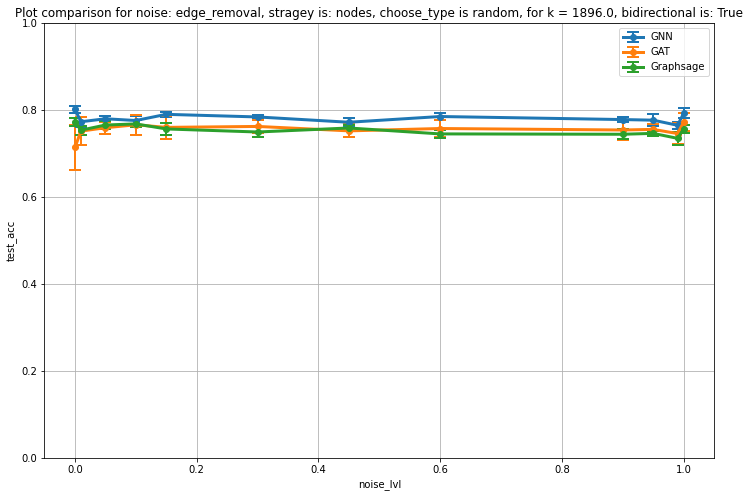

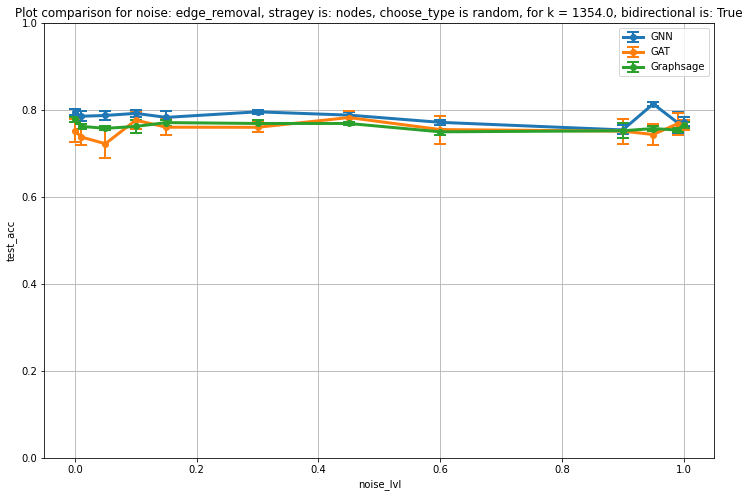

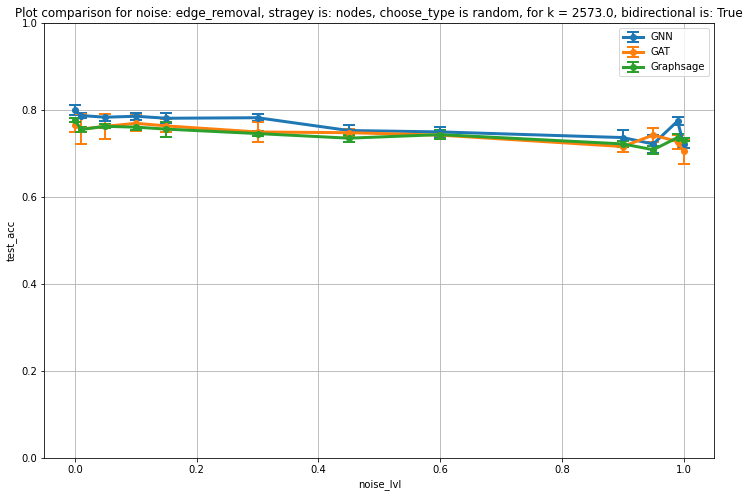

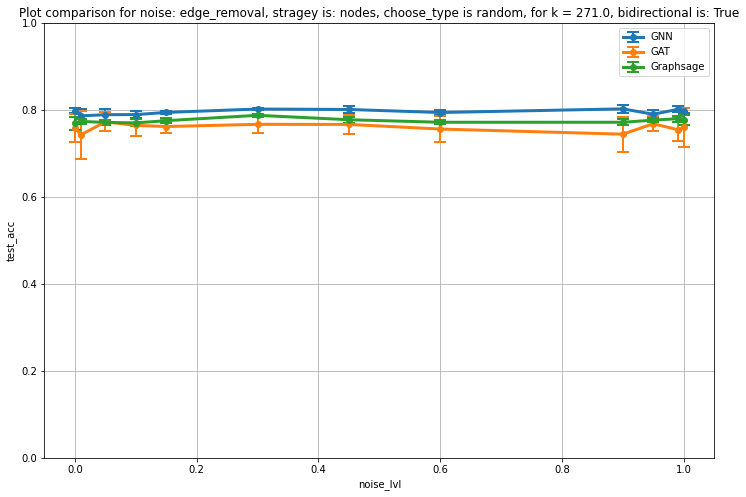

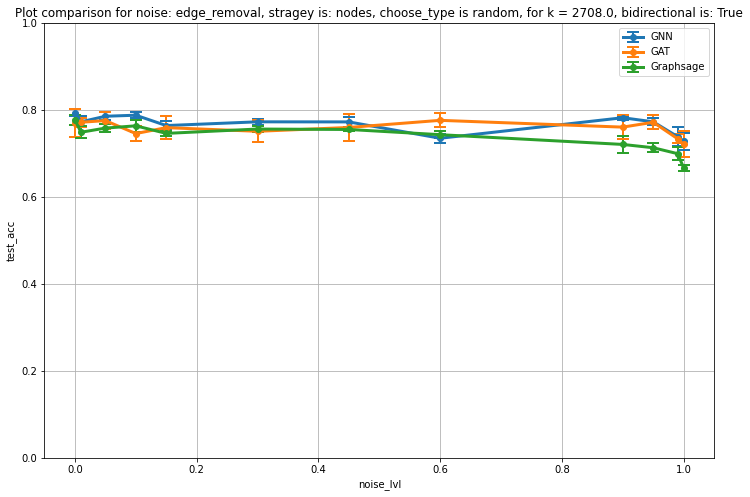

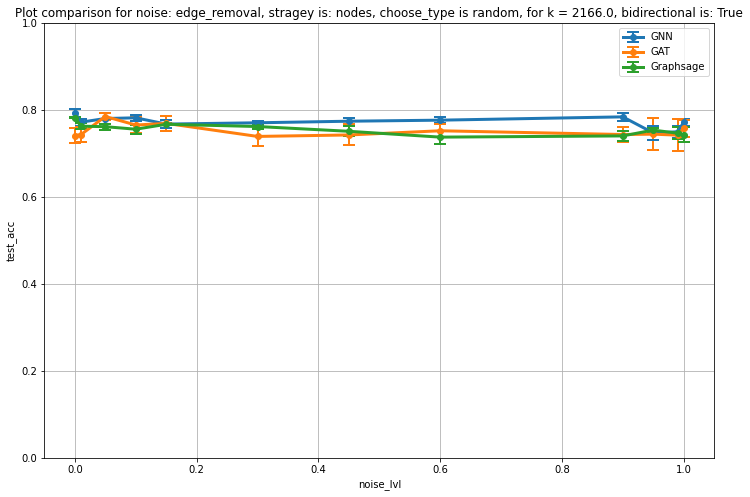

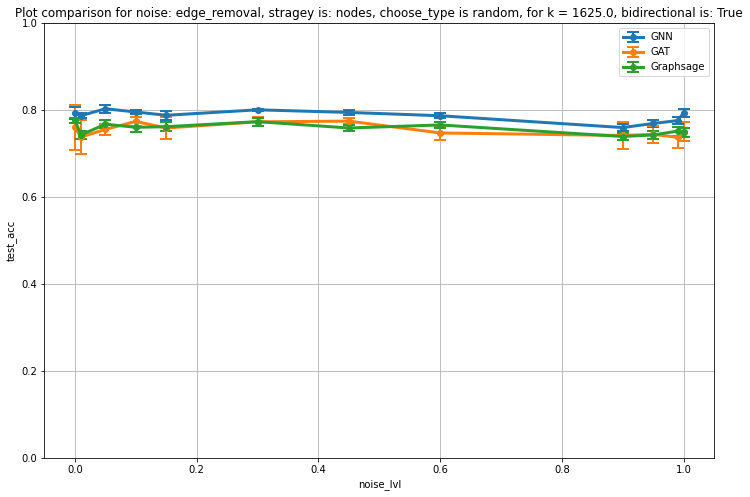

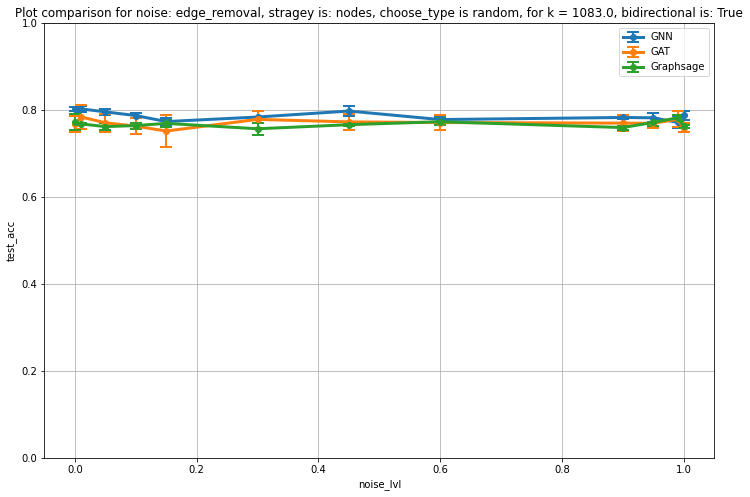

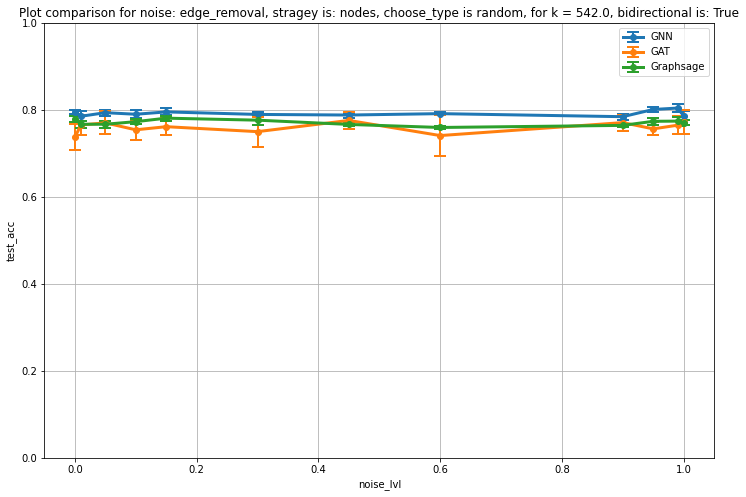

In [63]:
plot_comparison(data, 'edge_removal', 'nodes', 'random', k_nodes=list(k_nodes), bidirectional=False)
plot_comparison(data, 'edge_removal', 'nodes', 'random', k_nodes=list(k_nodes), bidirectional=True)

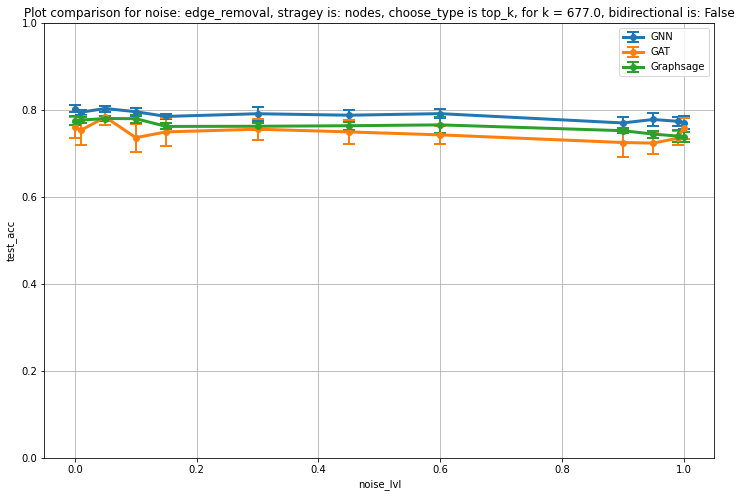

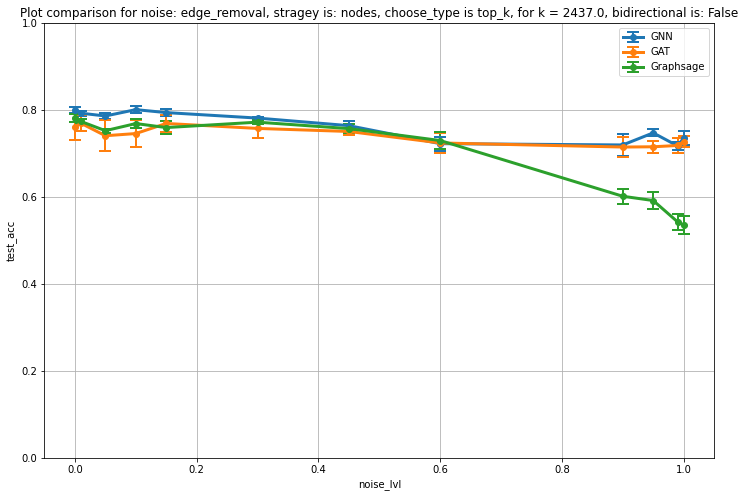

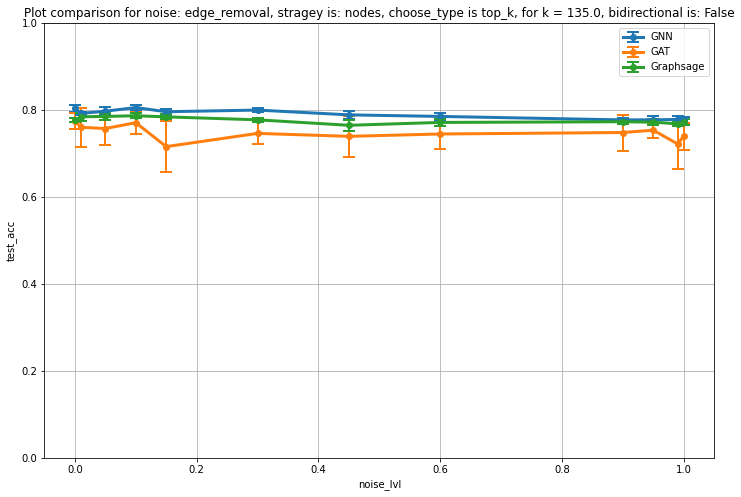

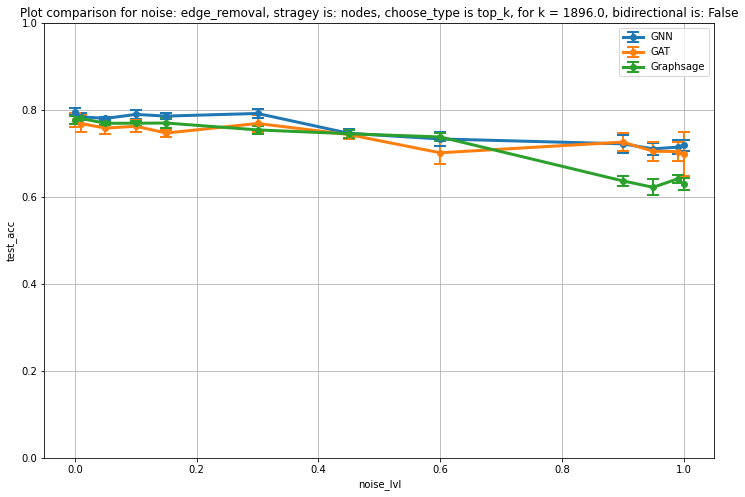

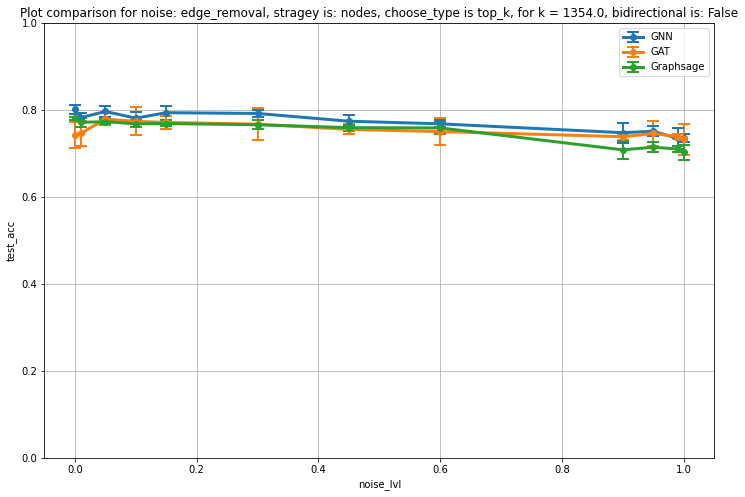

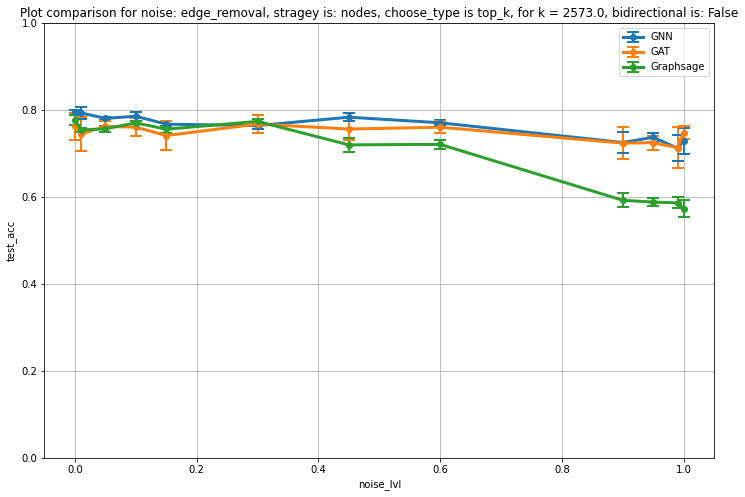

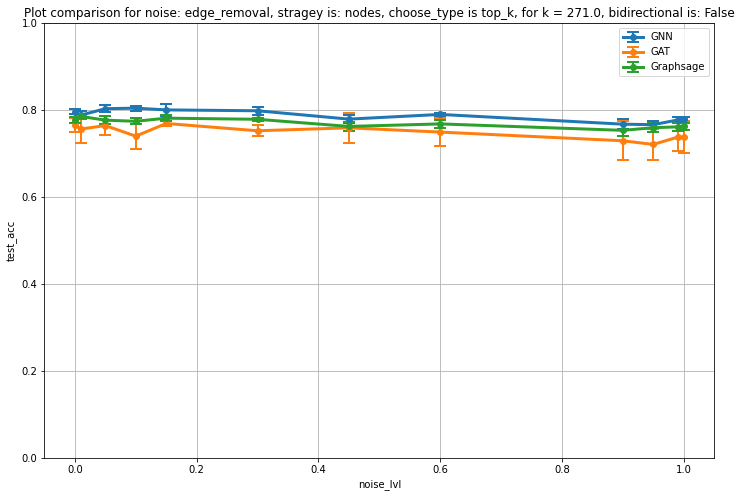

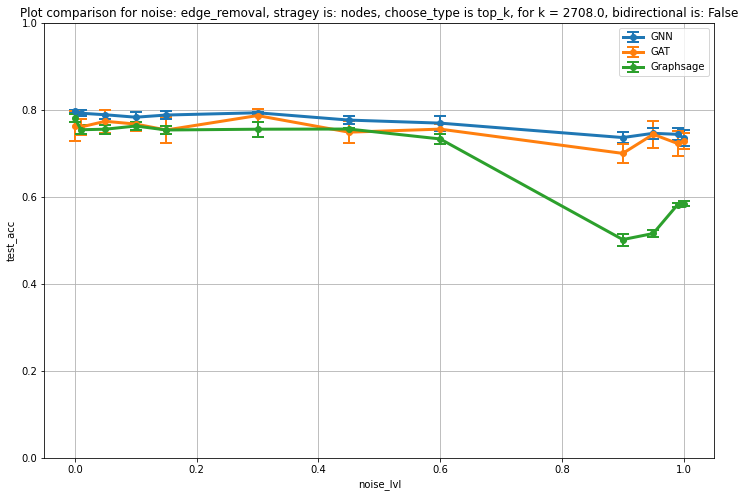

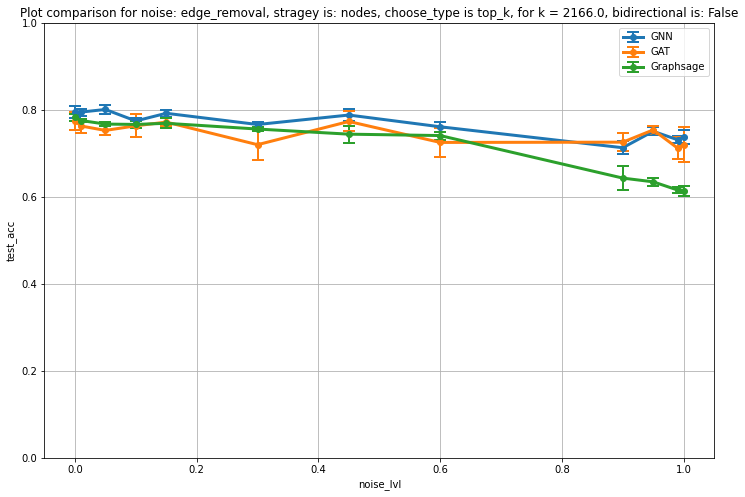

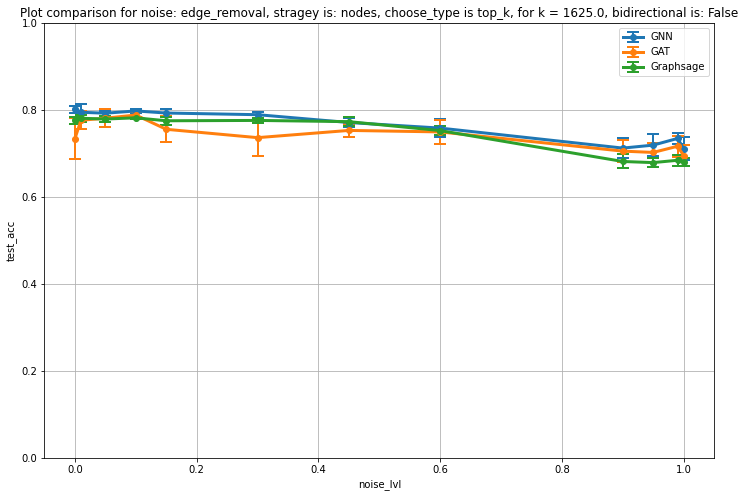

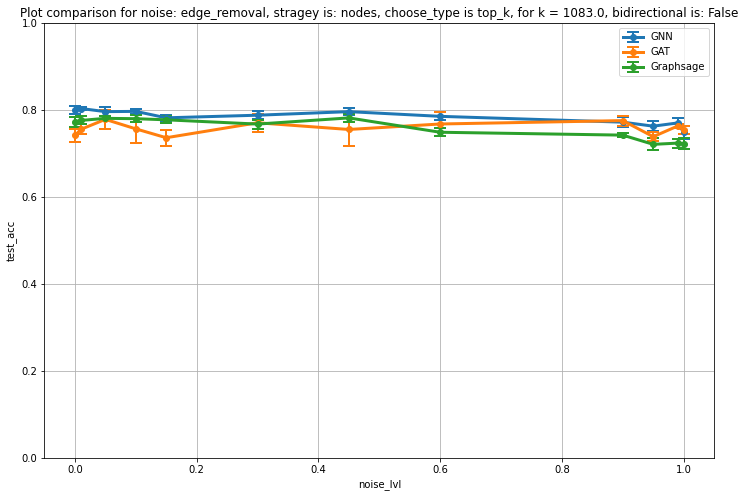

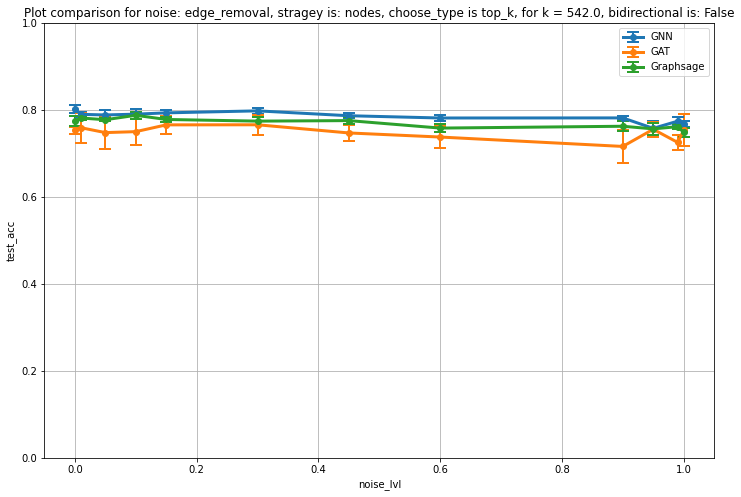

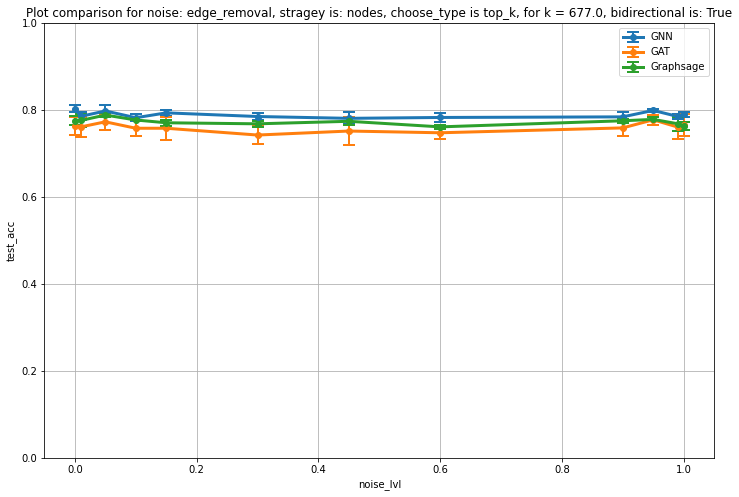

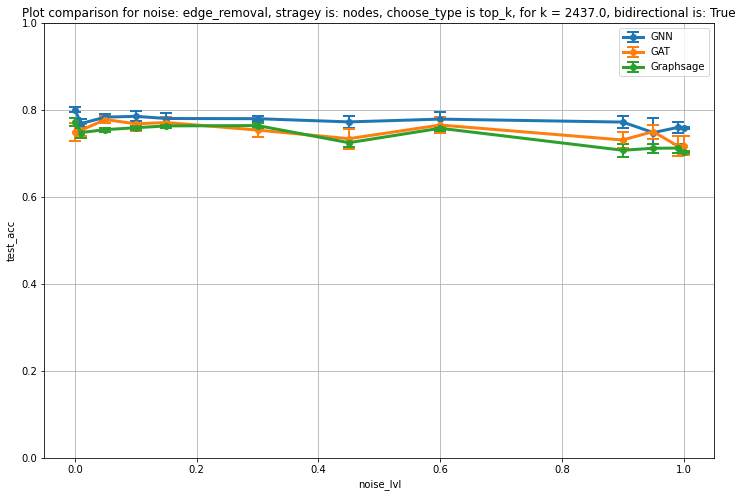

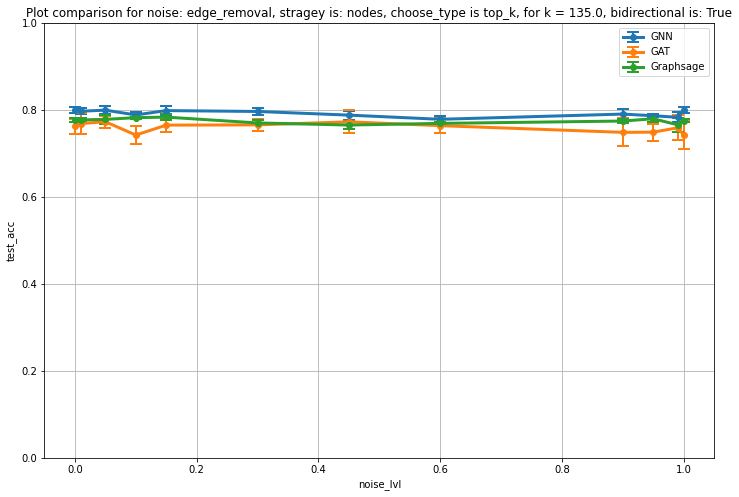

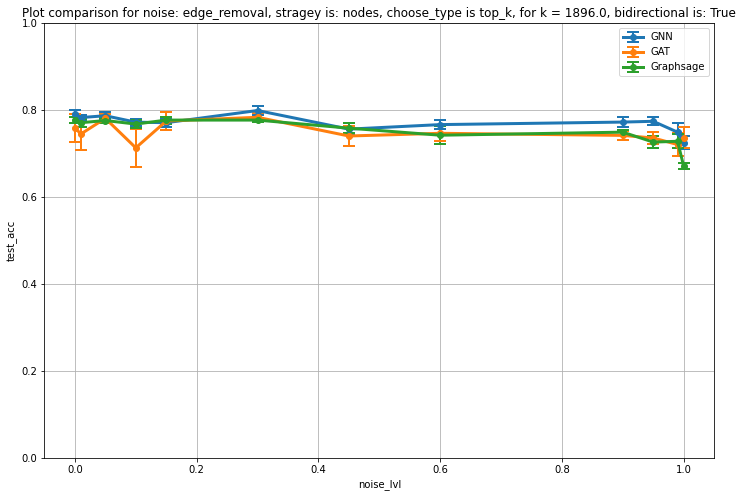

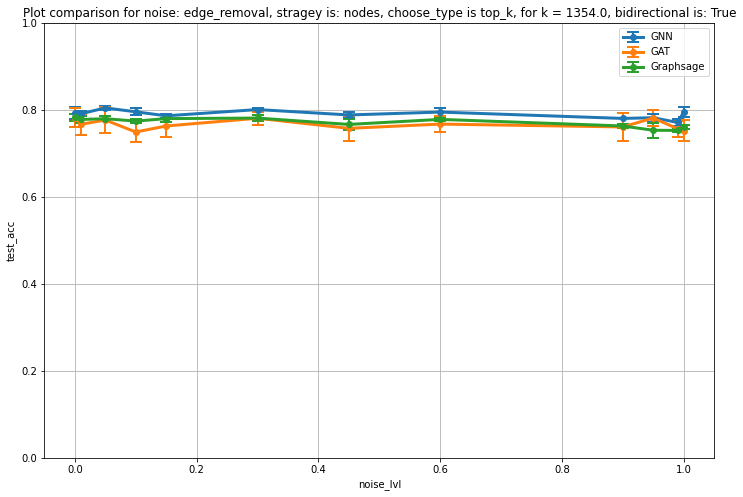

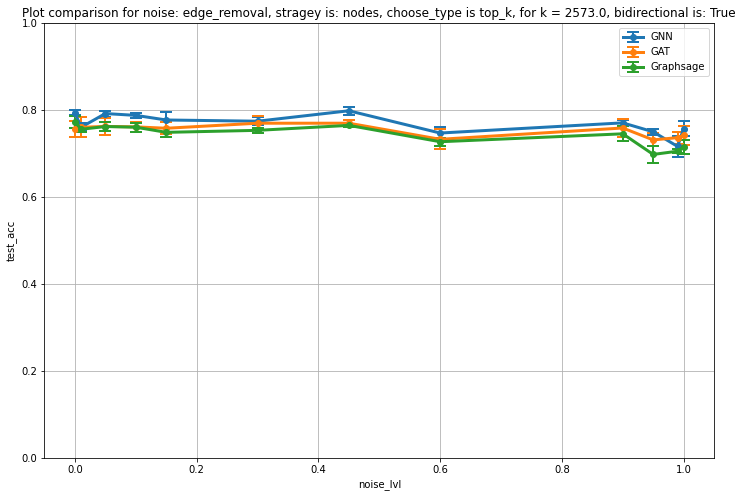

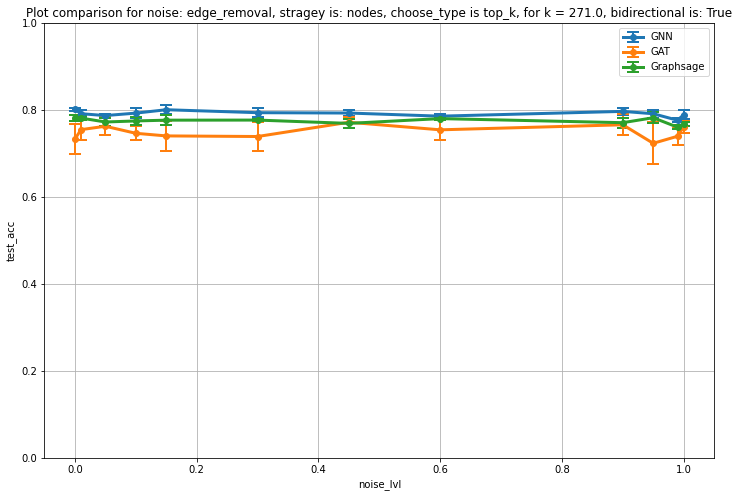

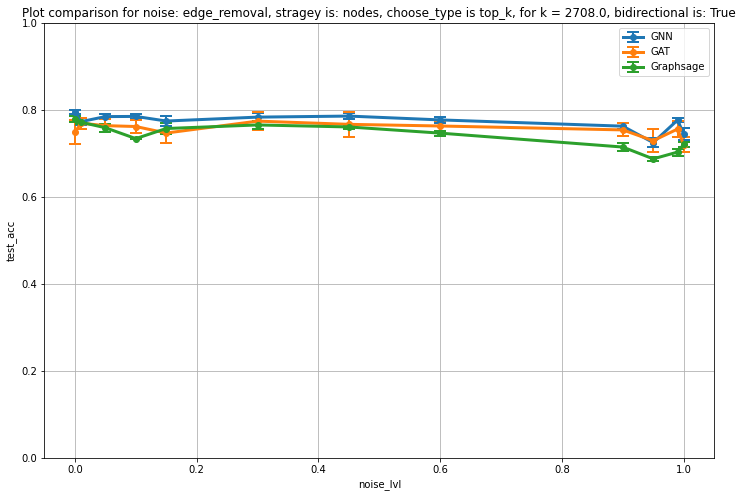

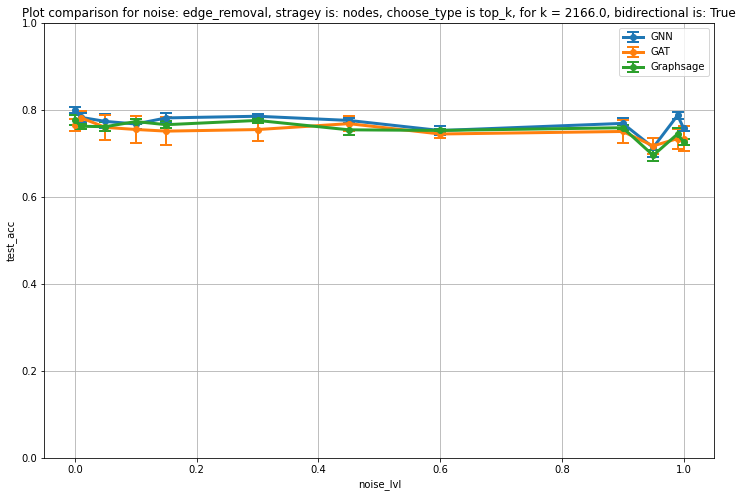

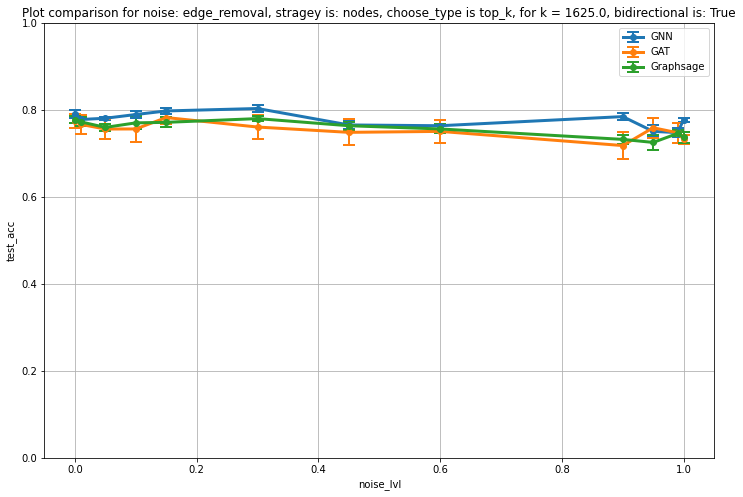

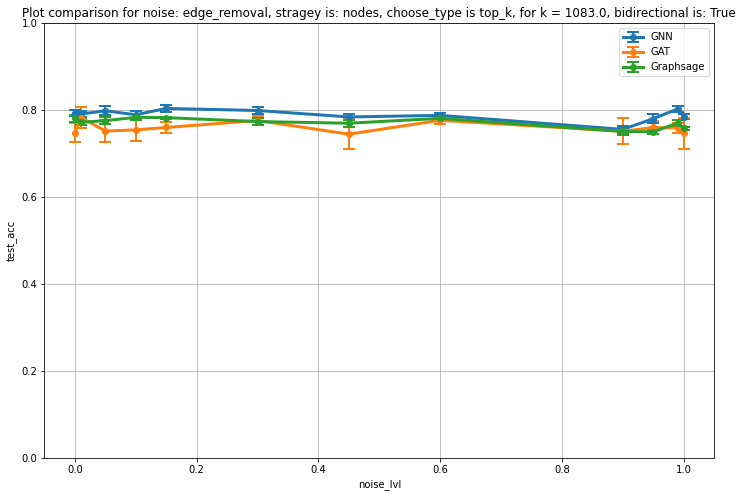

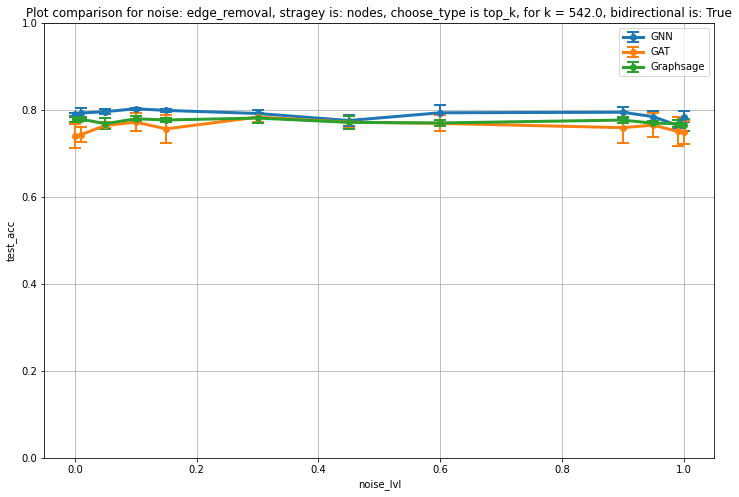

In [64]:
plot_comparison(data, 'edge_removal', 'nodes', 'top_k', k_nodes=list(k_nodes), bidirectional=False)
plot_comparison(data, 'edge_removal', 'nodes', 'top_k', k_nodes=list(k_nodes), bidirectional=True)

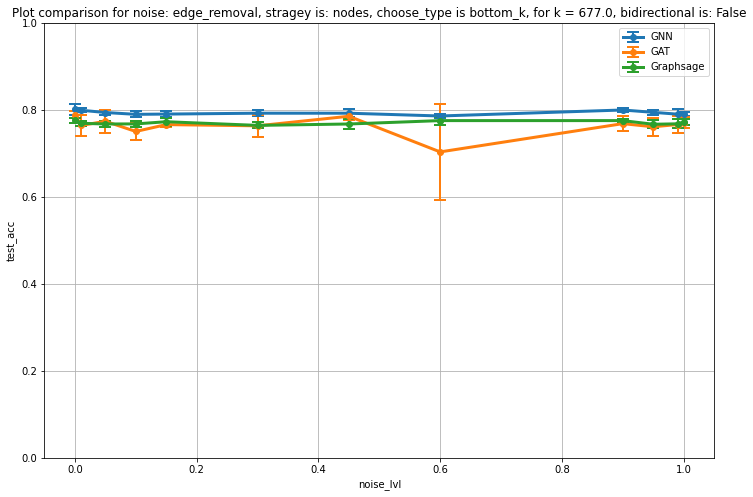

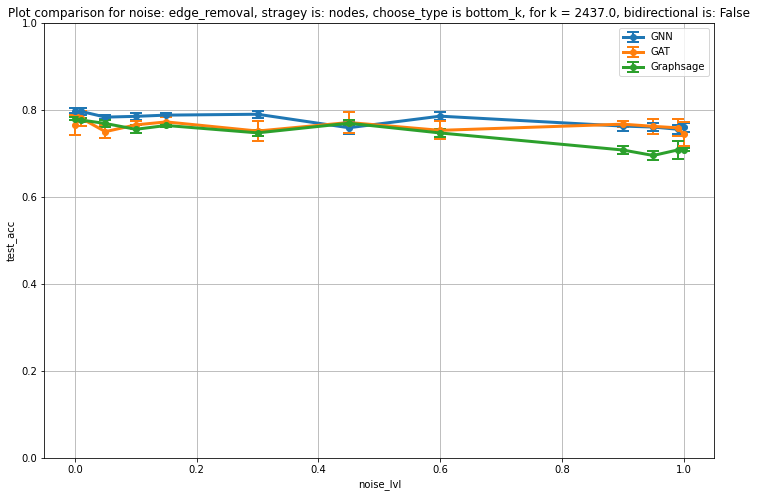

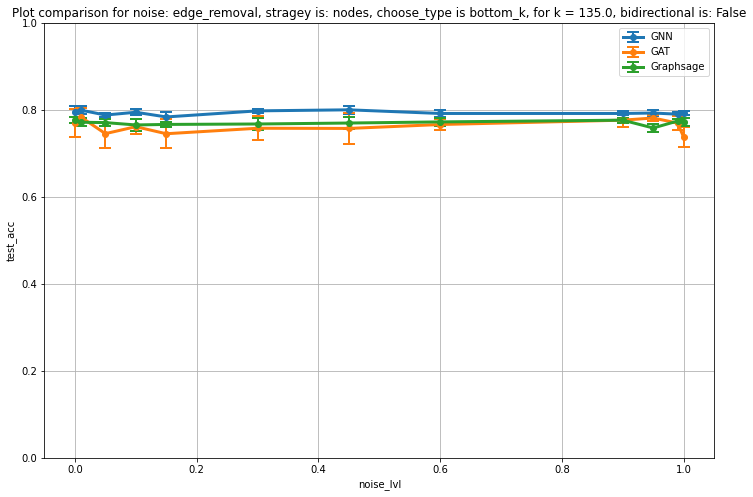

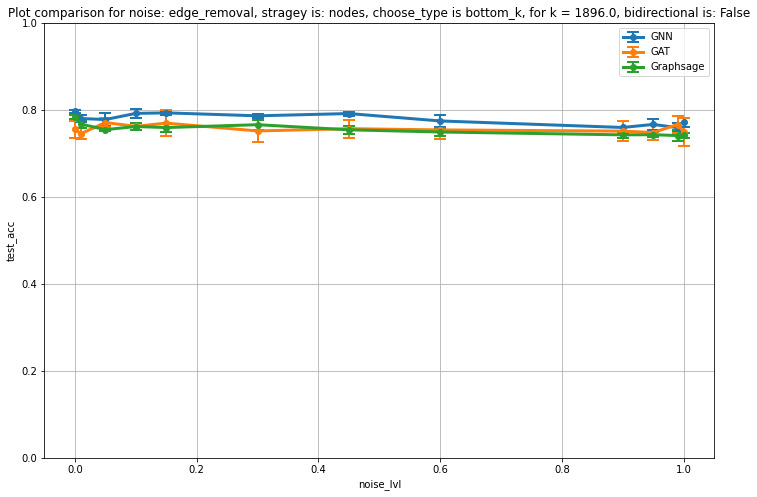

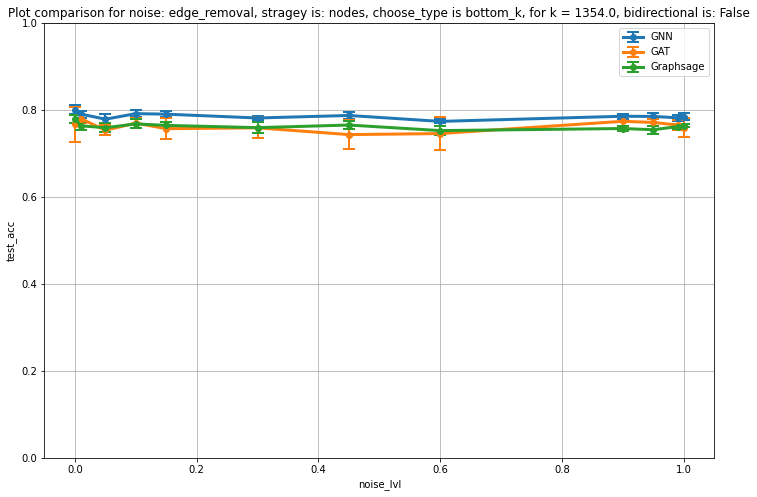

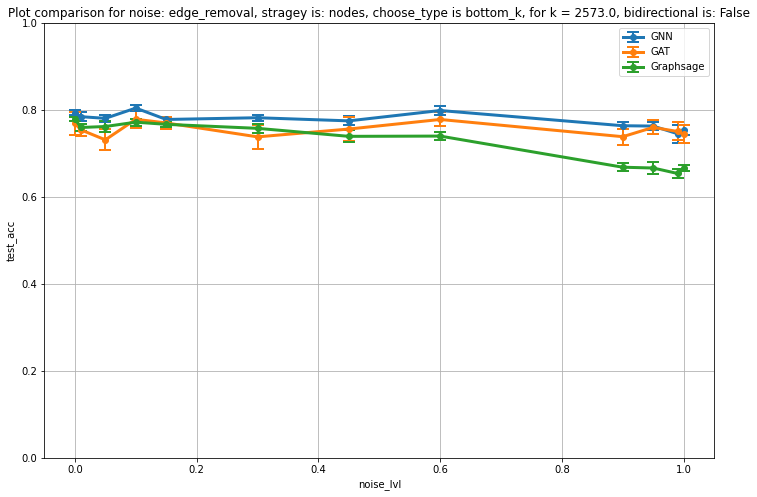

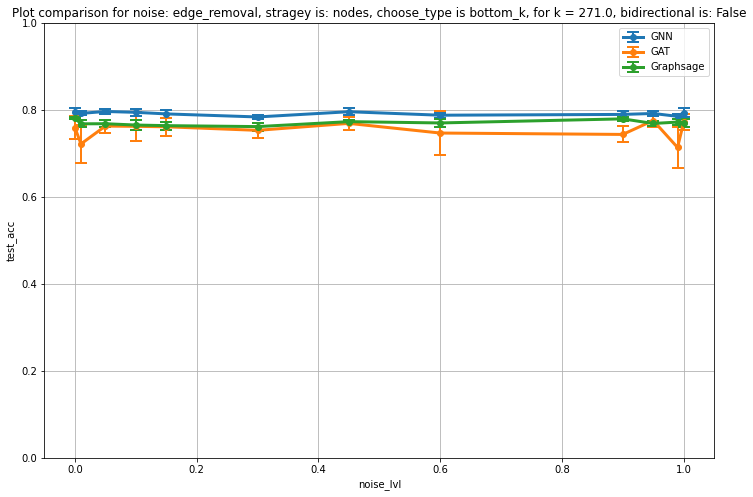

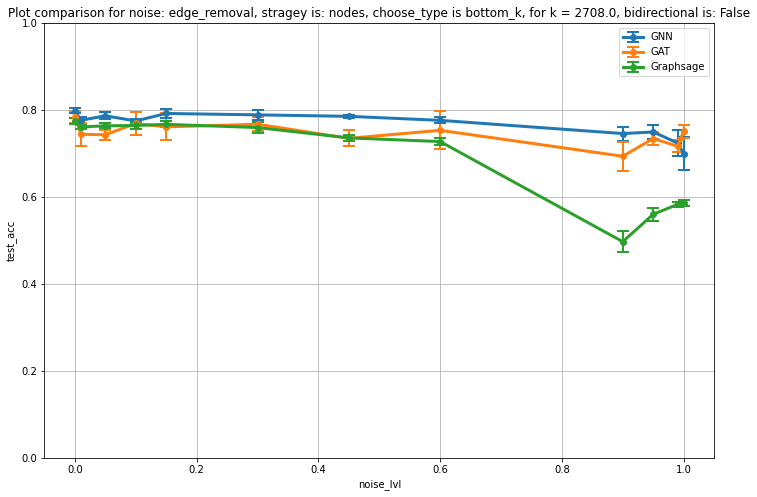

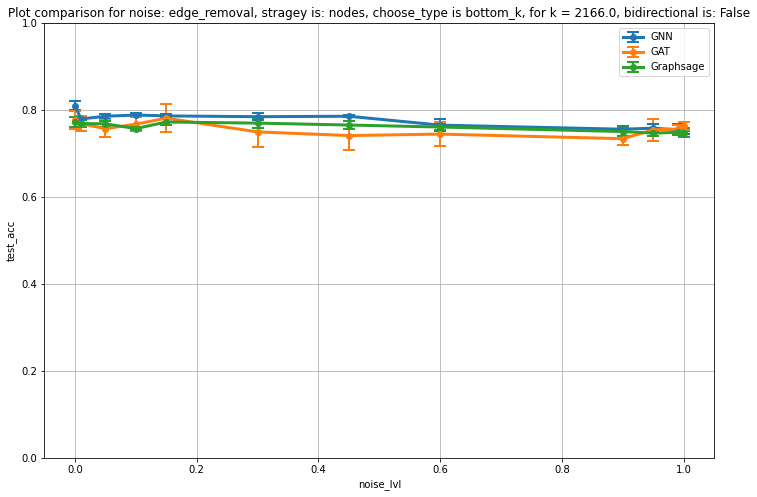

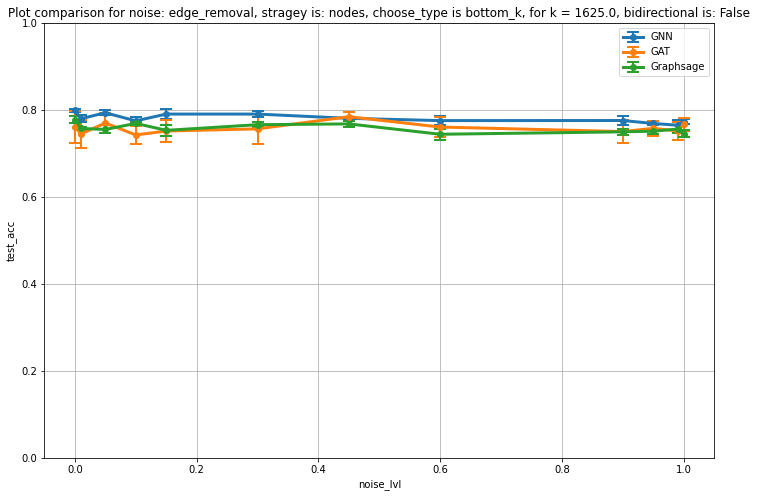

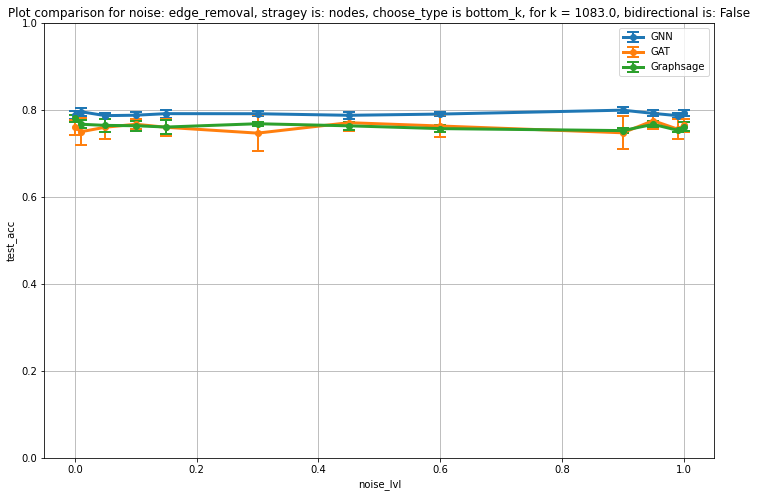

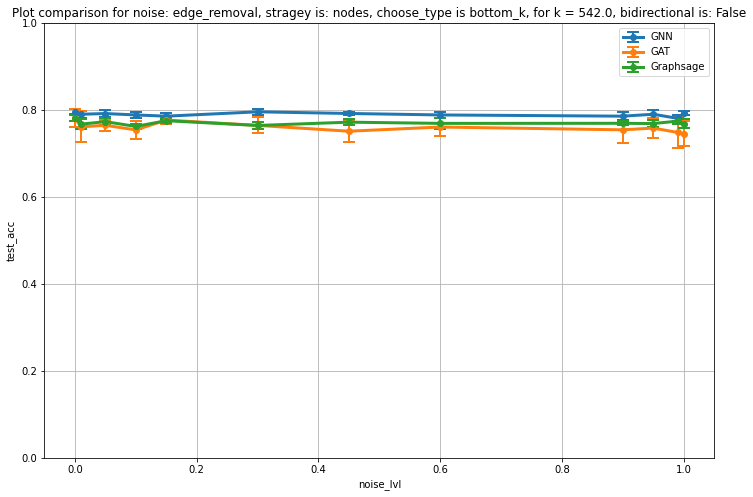

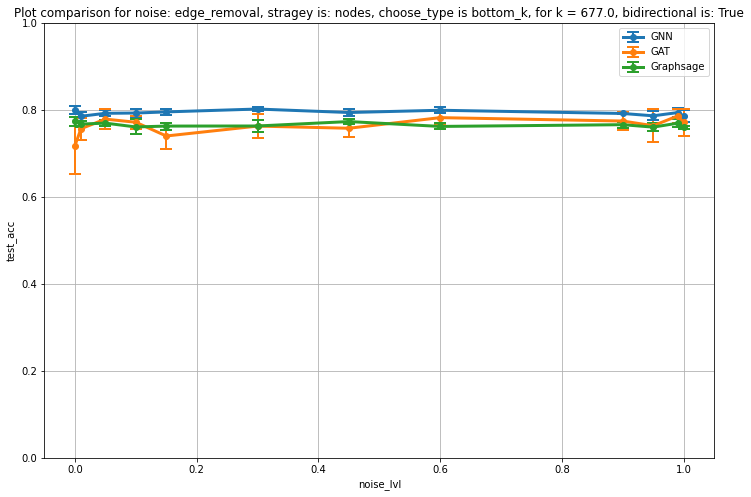

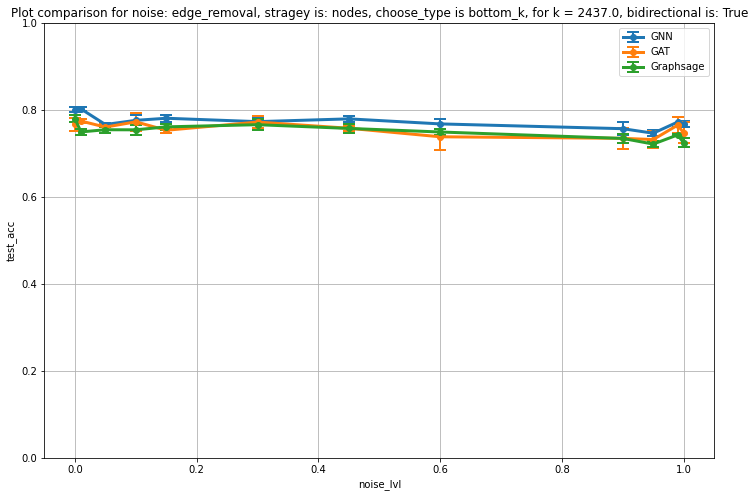

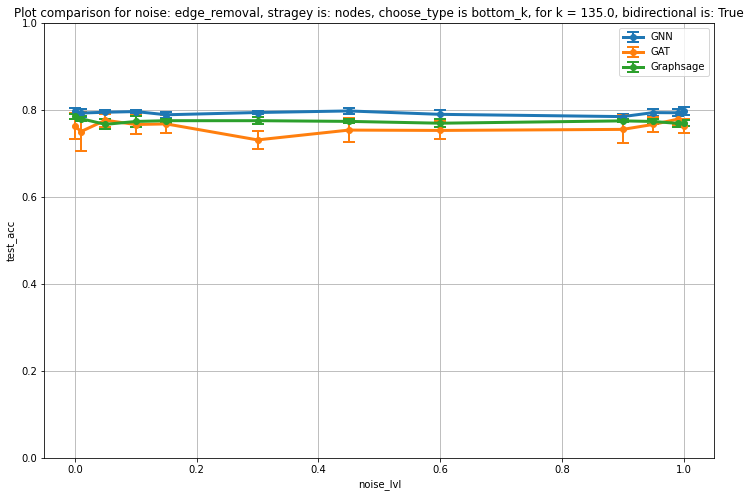

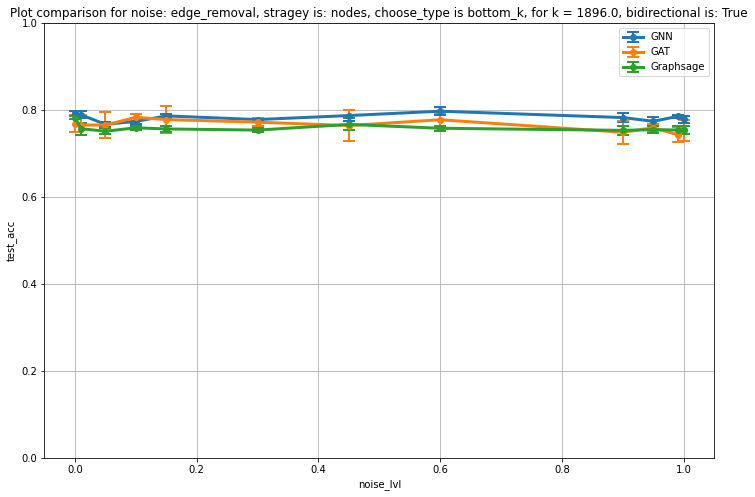

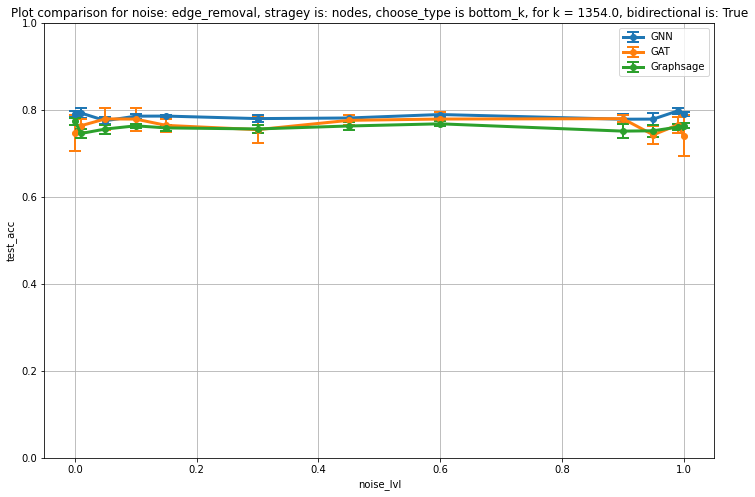

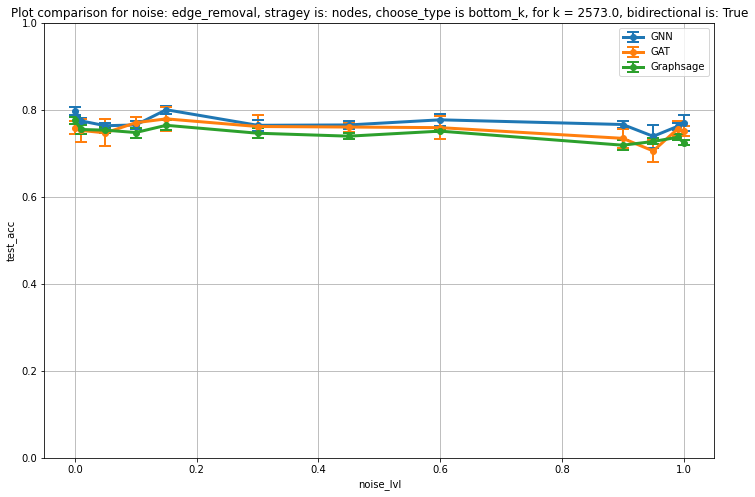

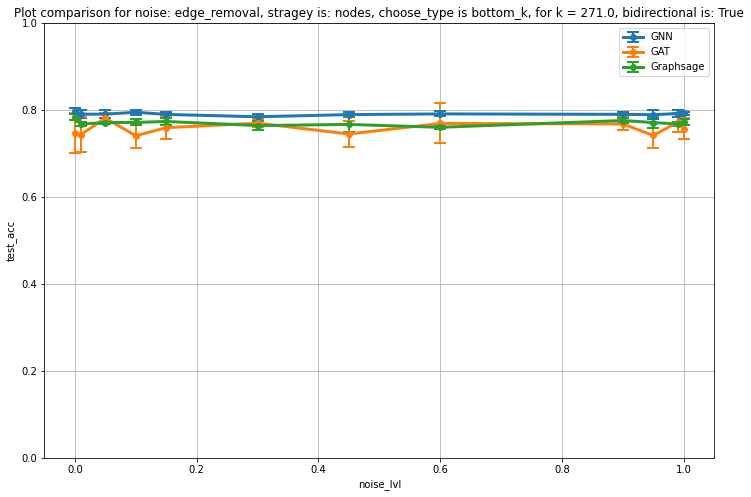

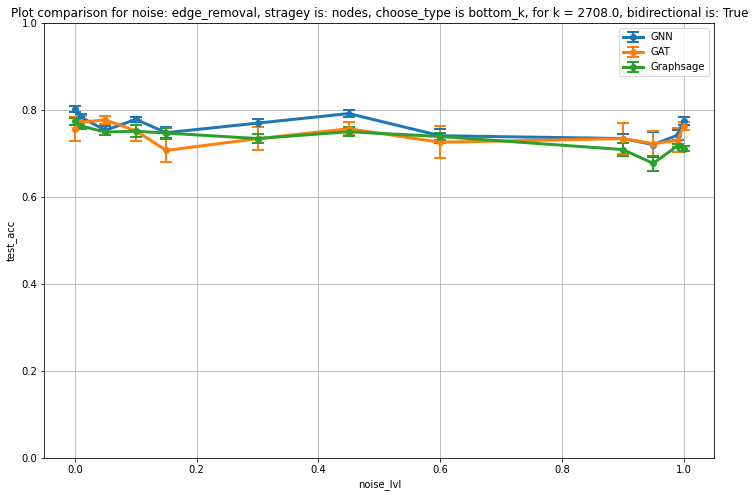

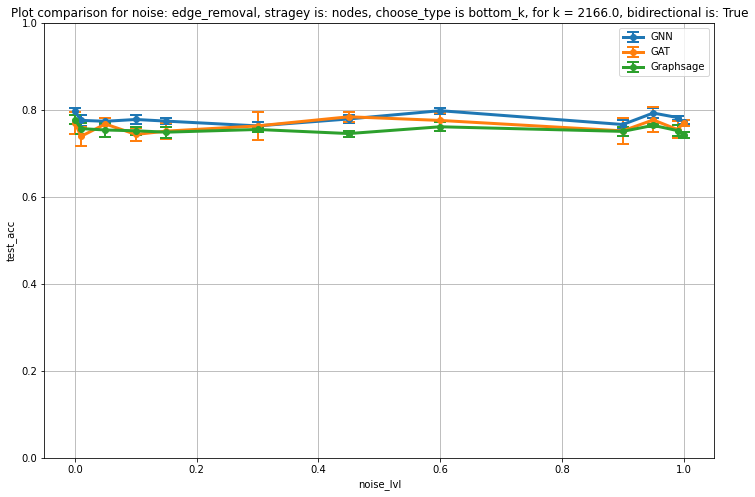

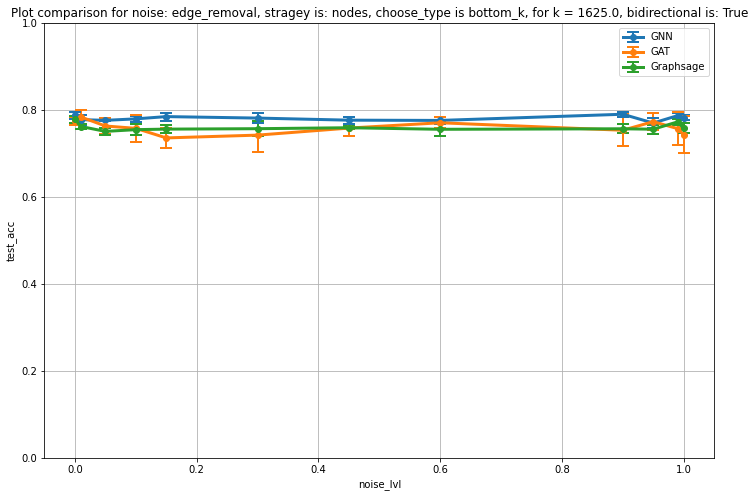

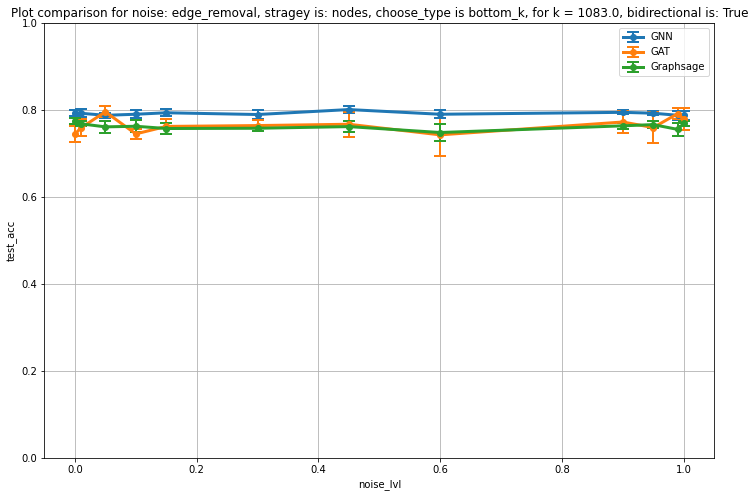

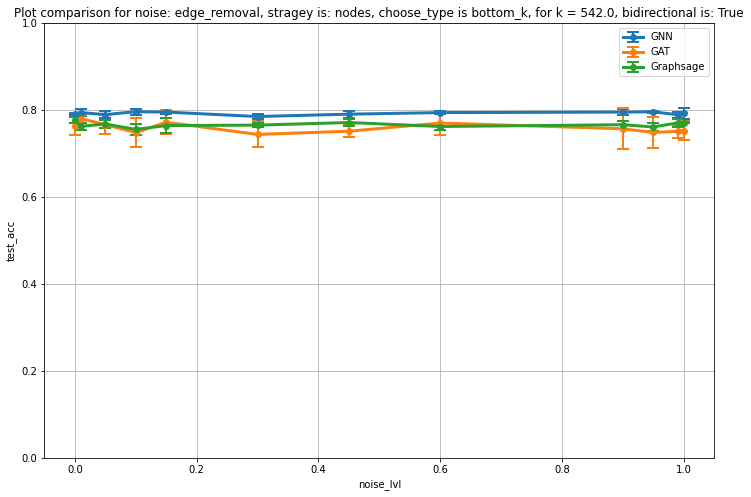

In [65]:
plot_comparison(data, 'edge_removal', 'nodes', 'bottom_k', k_nodes=list(k_nodes), bidirectional=False)
plot_comparison(data, 'edge_removal', 'nodes', 'bottom_k', k_nodes=list(k_nodes), bidirectional=True)

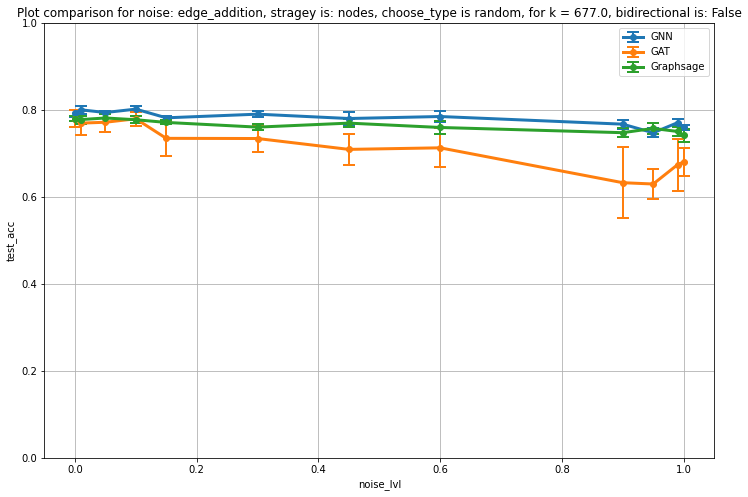

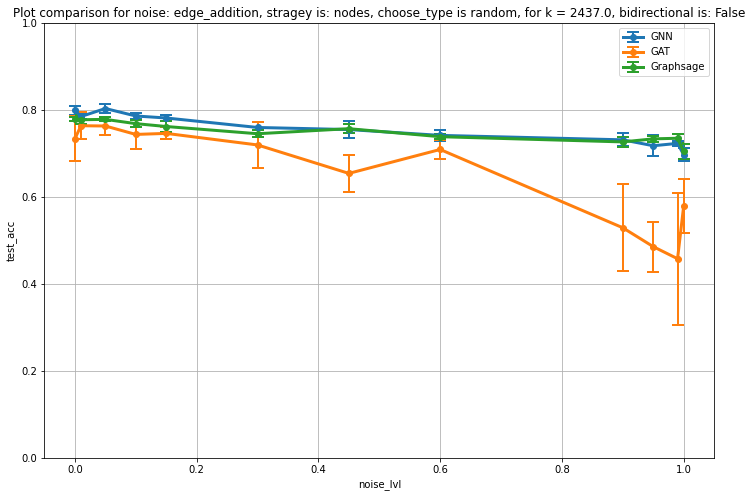

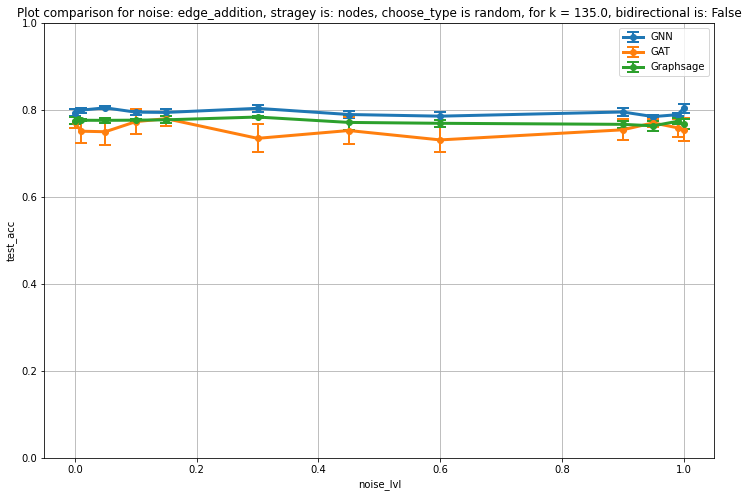

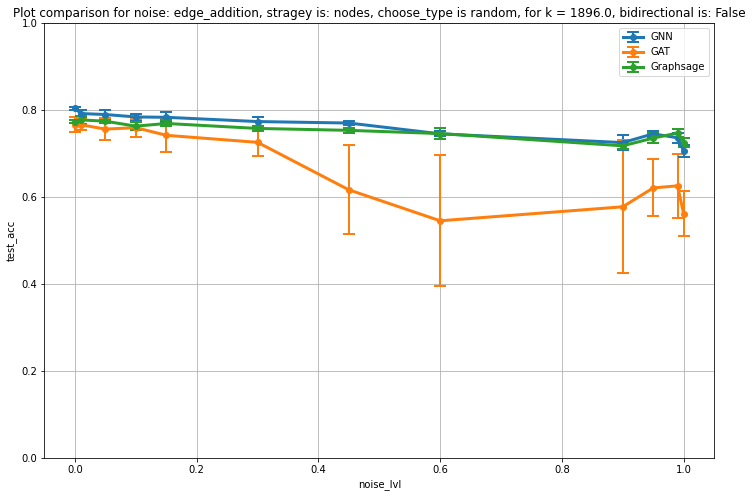

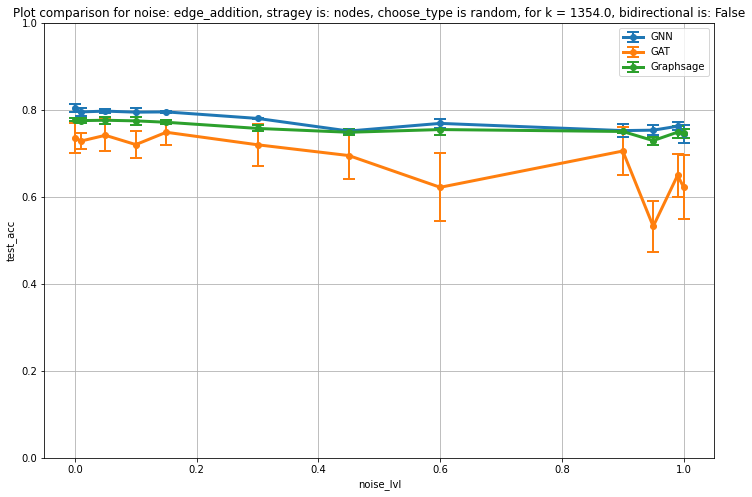

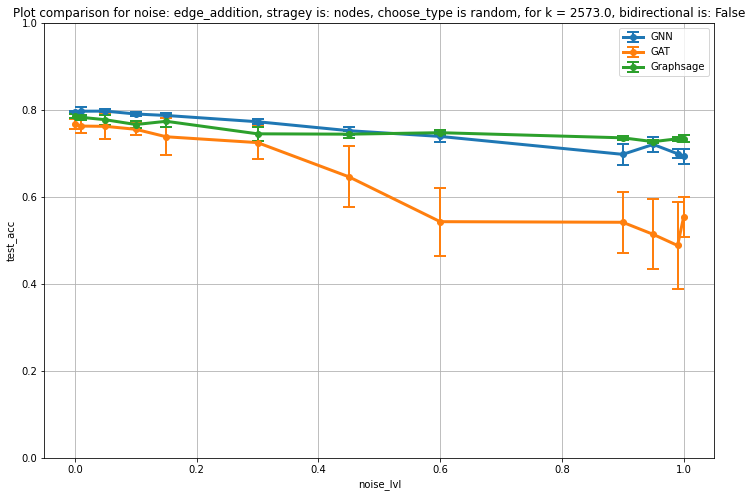

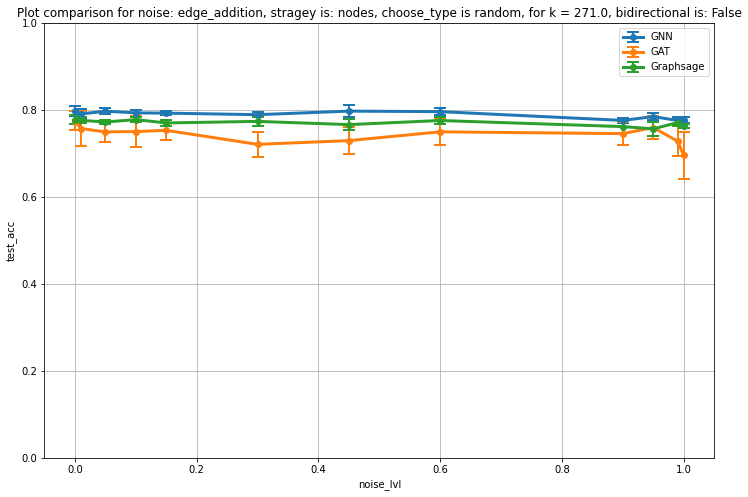

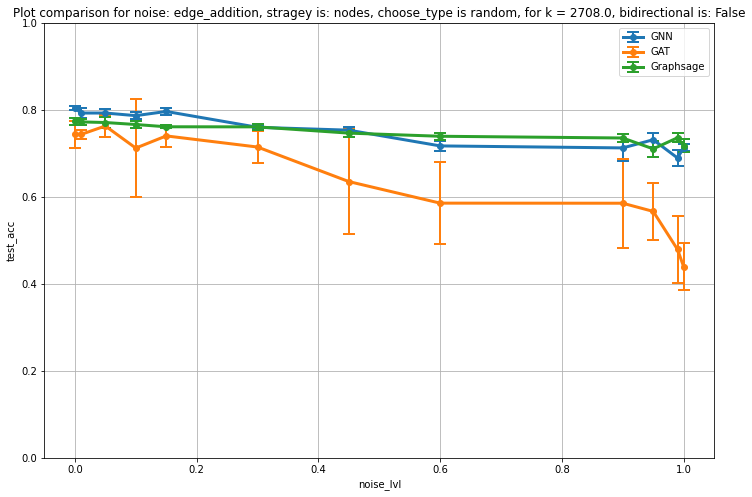

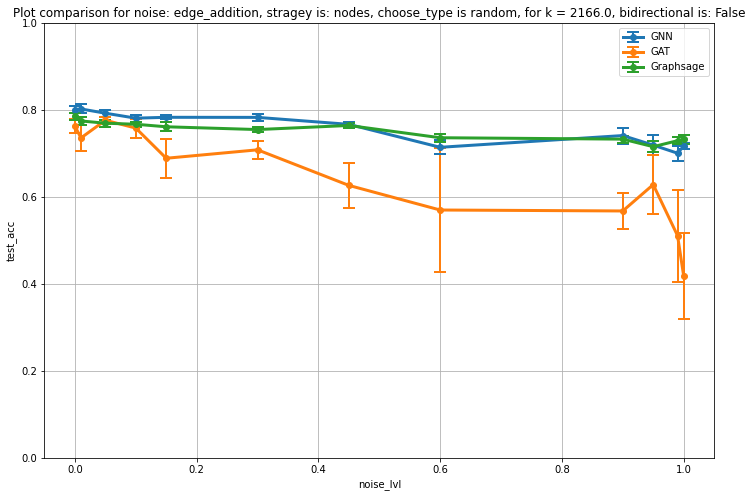

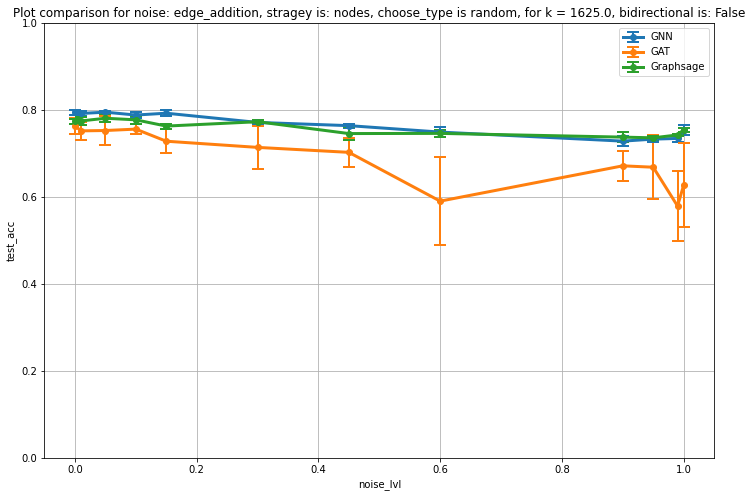

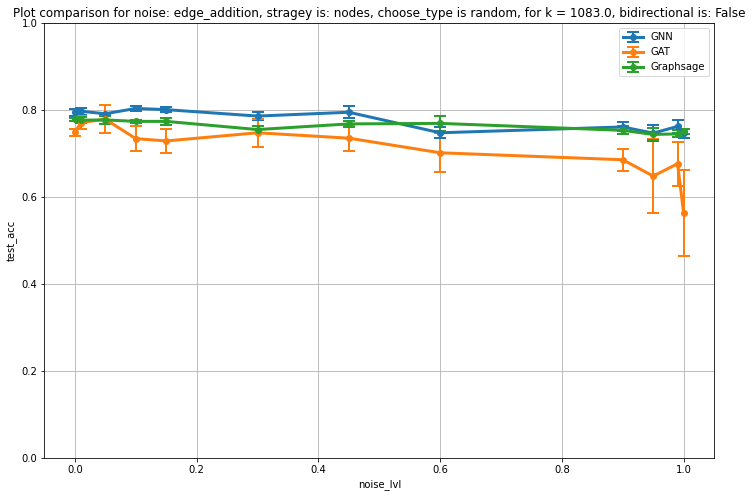

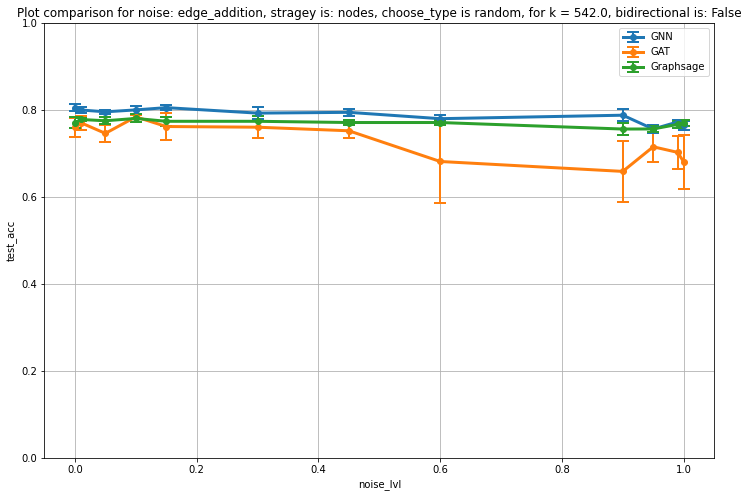

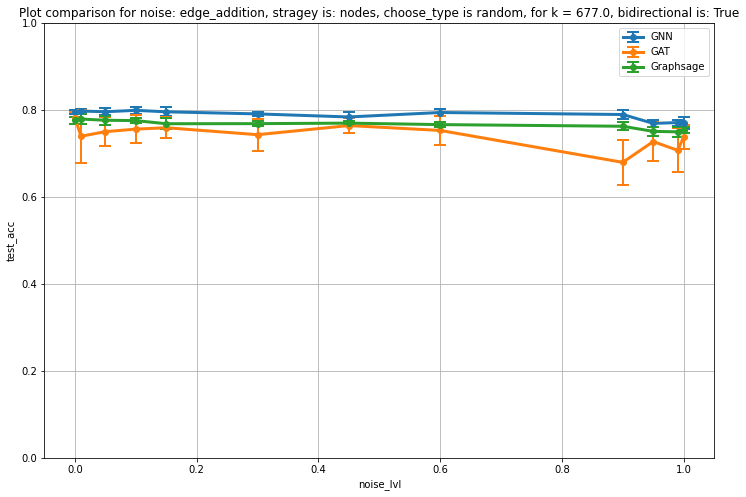

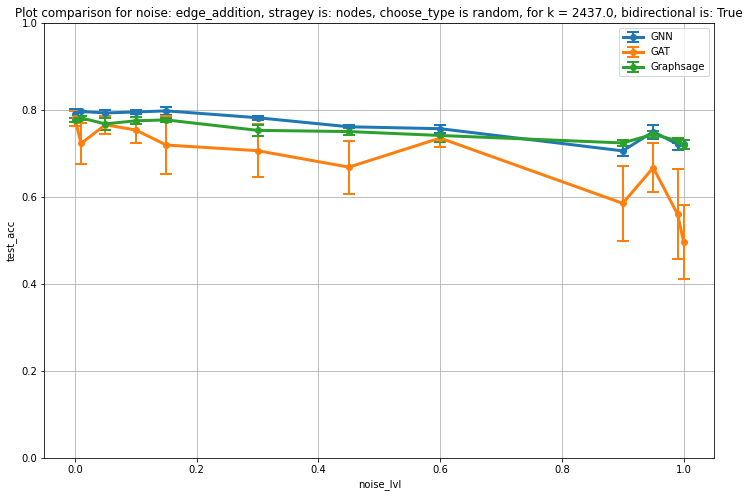

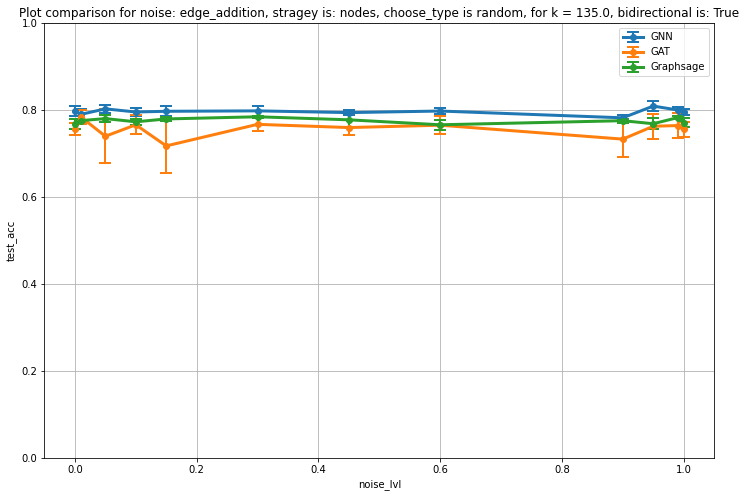

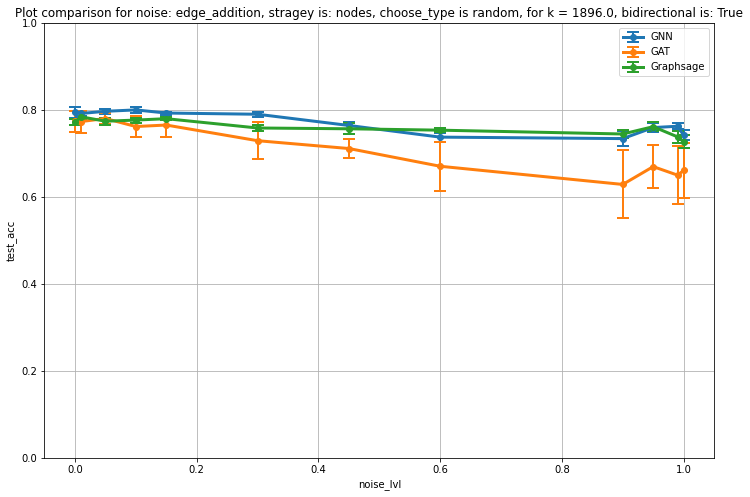

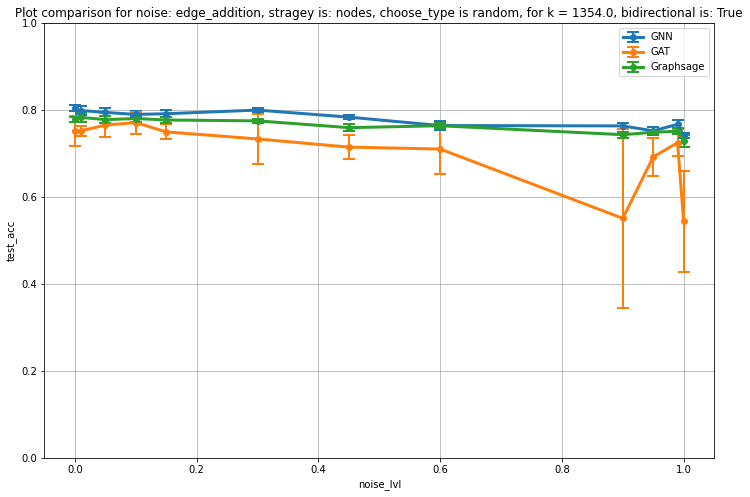

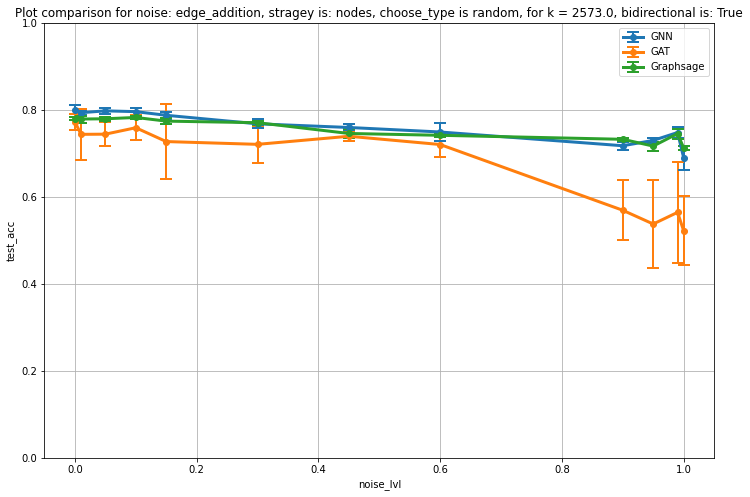

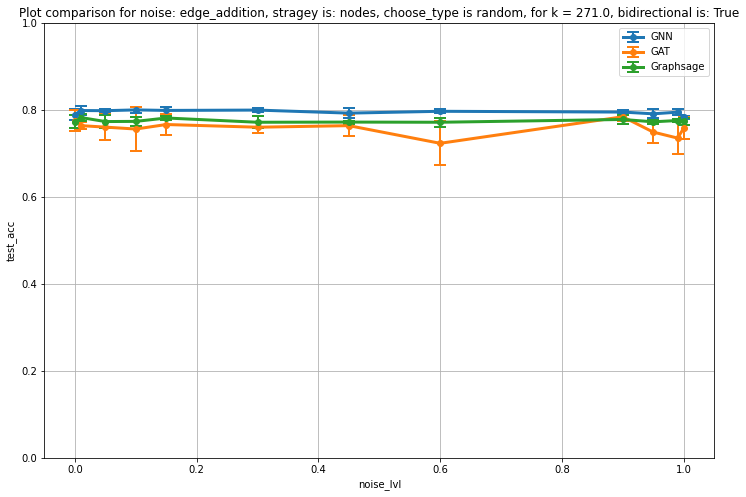

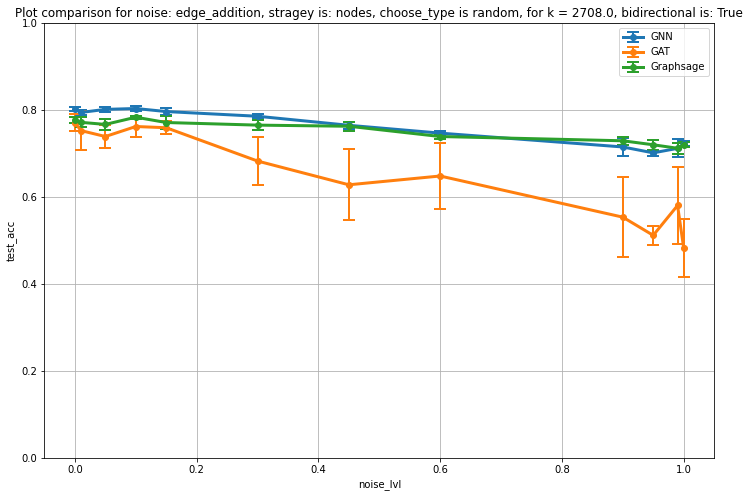

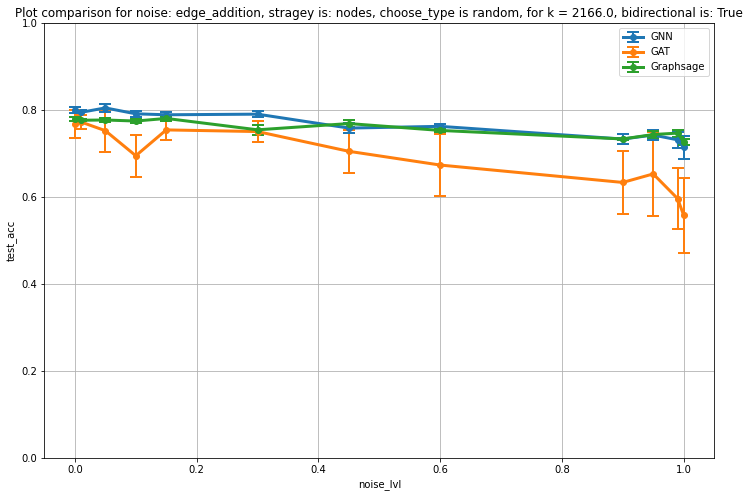

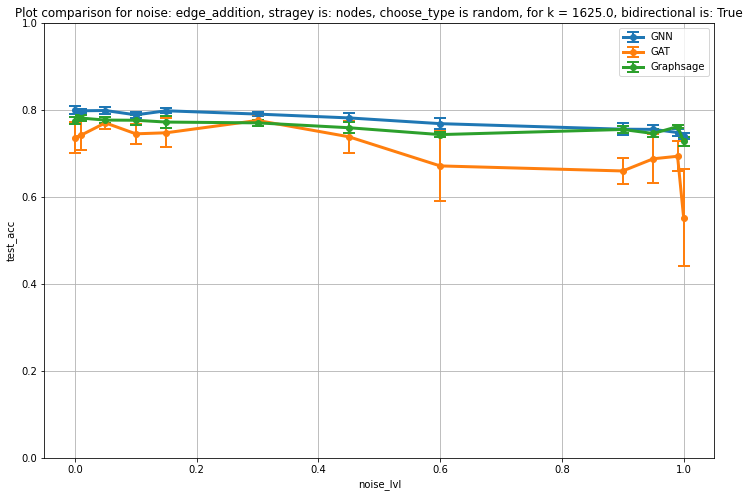

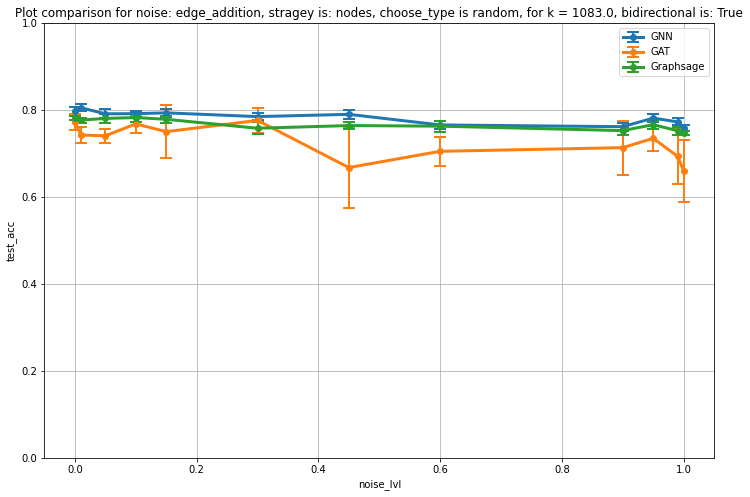

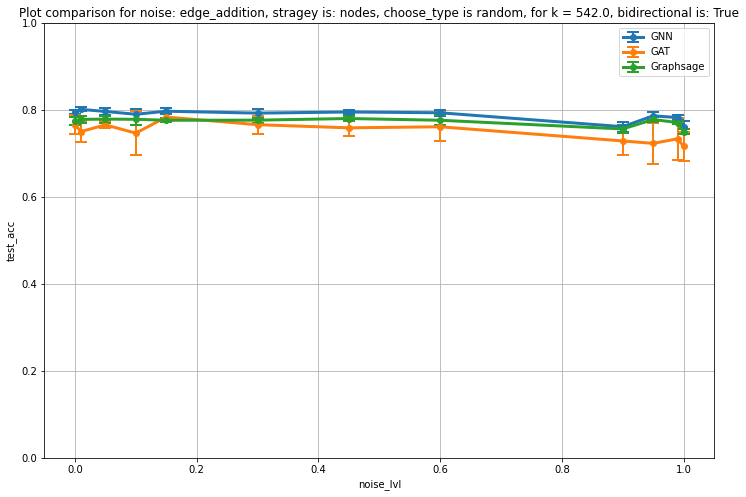

In [66]:
plot_comparison(data, 'edge_addition', 'nodes', 'random', k_nodes=list(k_nodes), bidirectional=False)
plot_comparison(data, 'edge_addition', 'nodes', 'random', k_nodes=list(k_nodes), bidirectional=True)

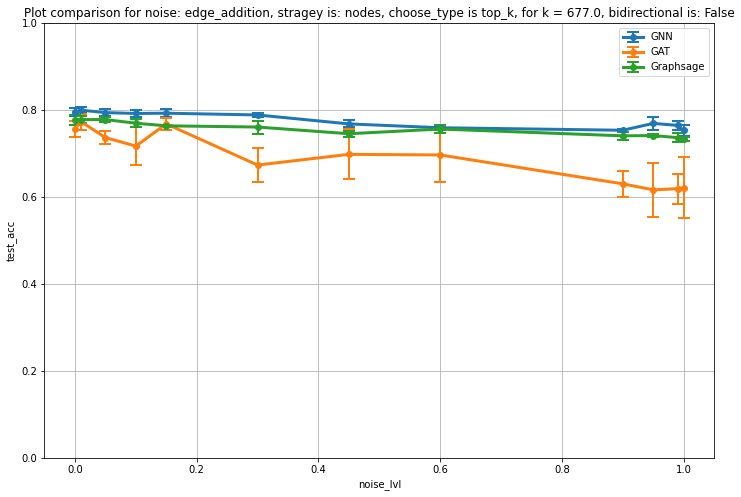

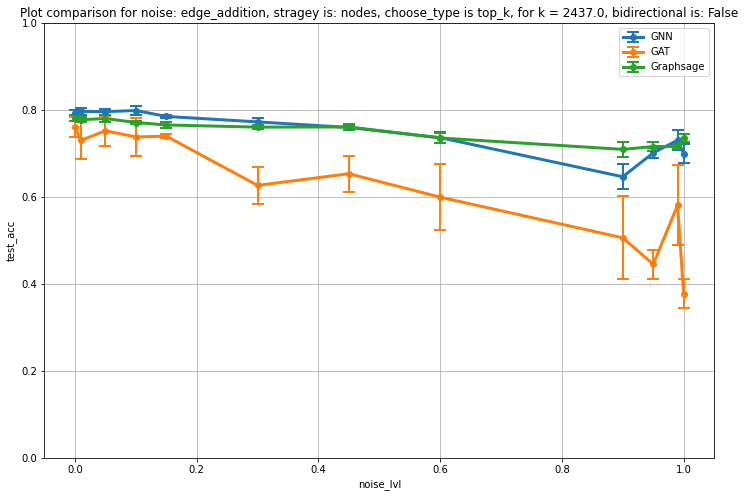

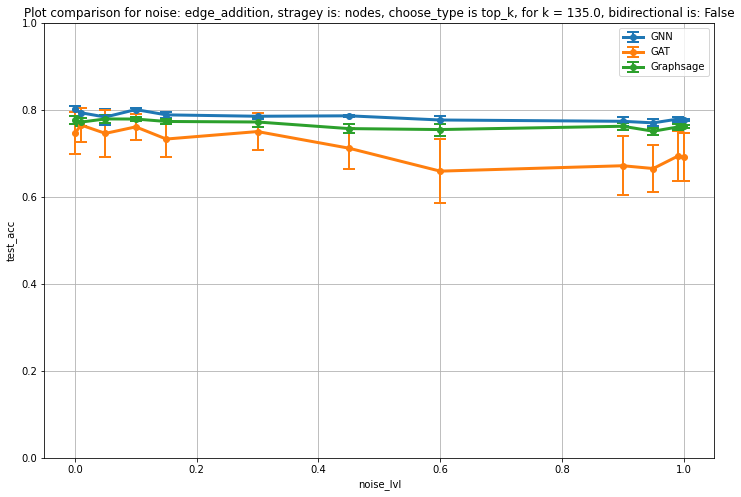

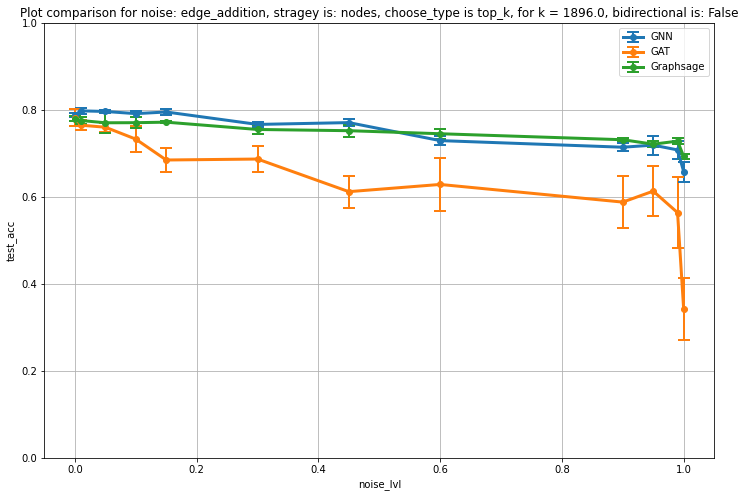

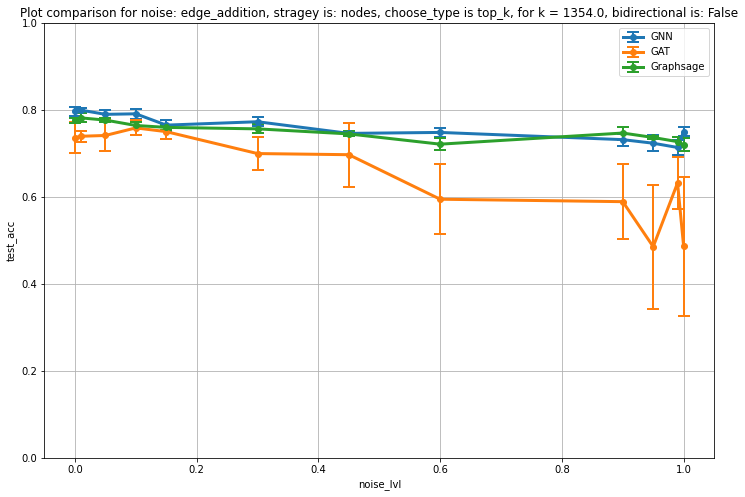

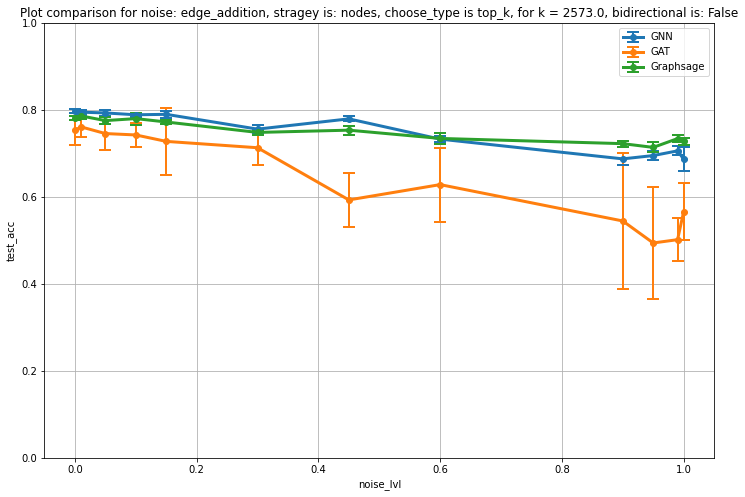

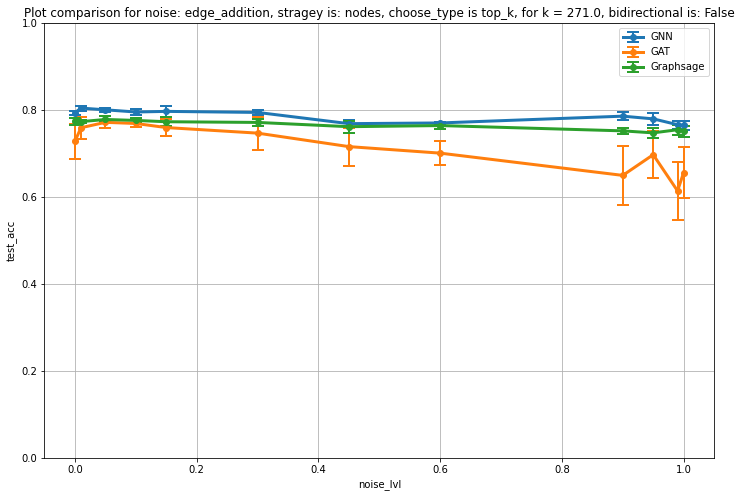

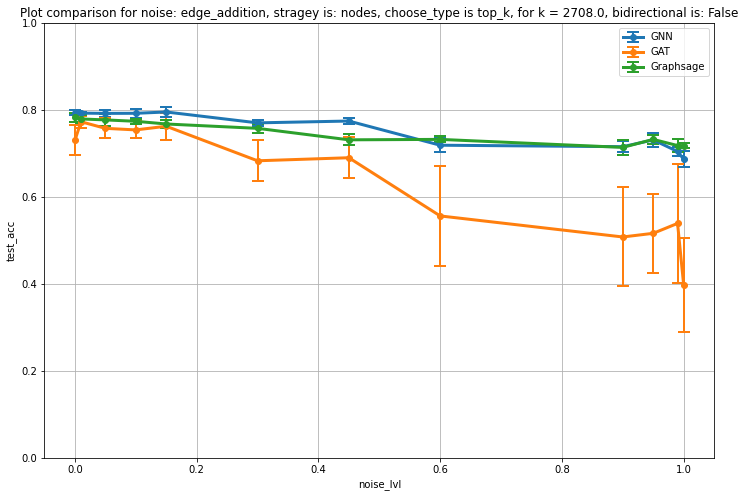

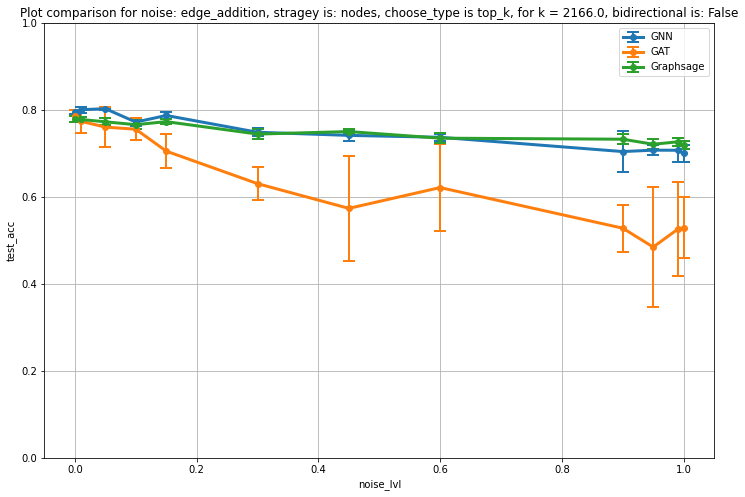

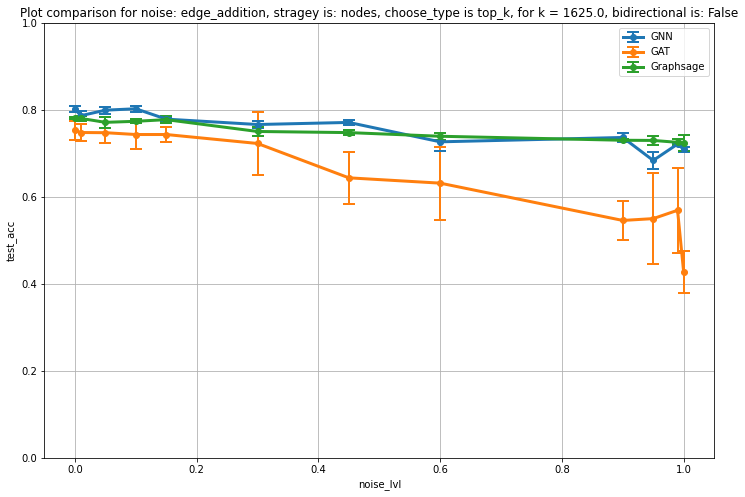

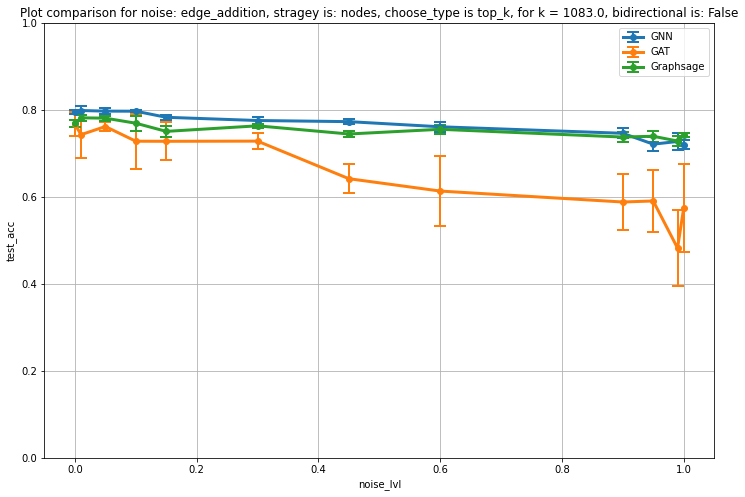

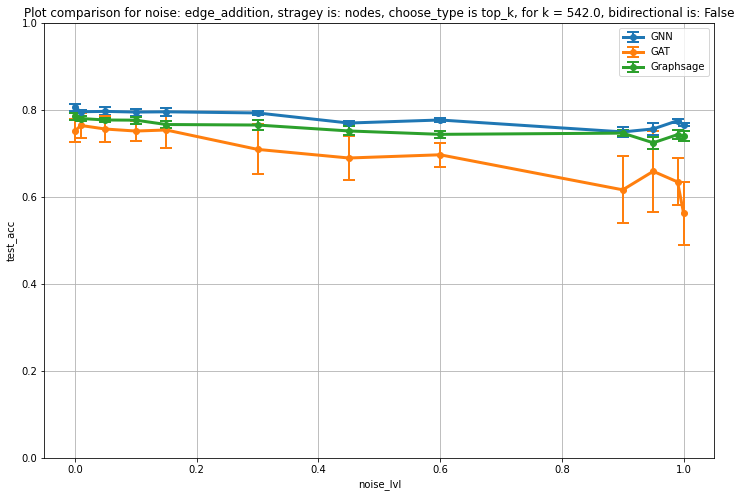

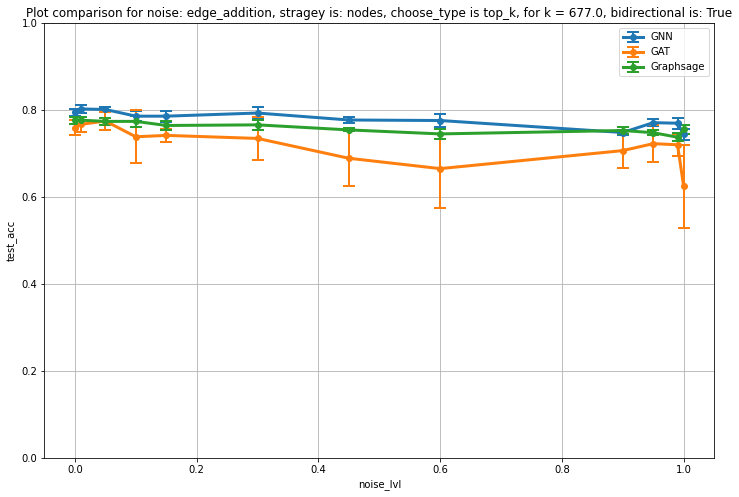

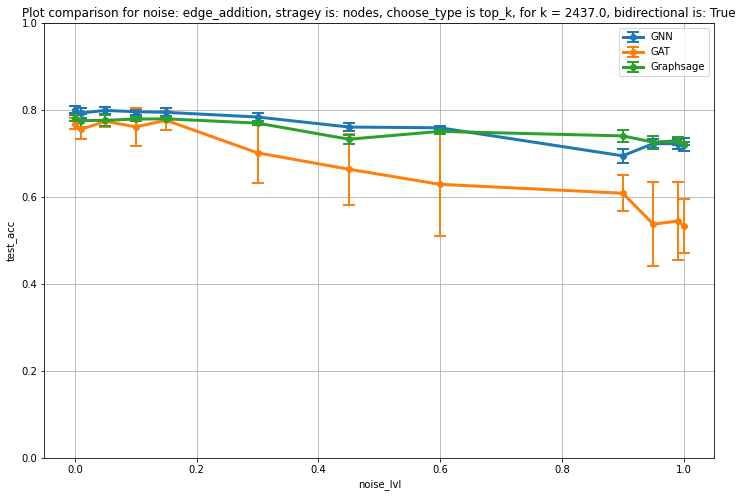

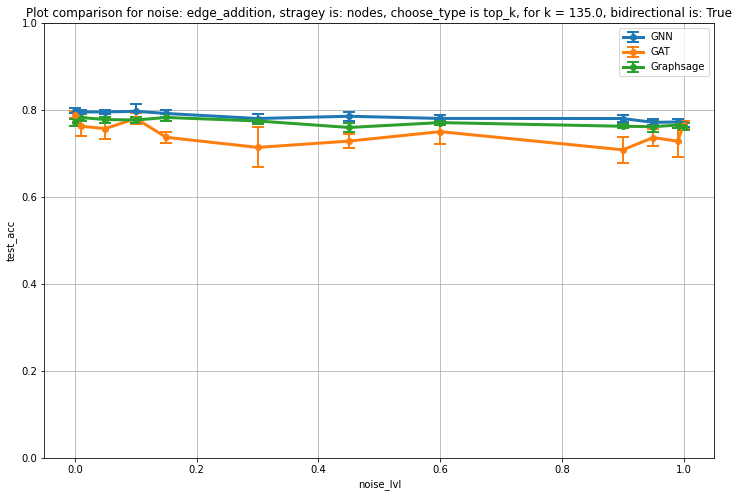

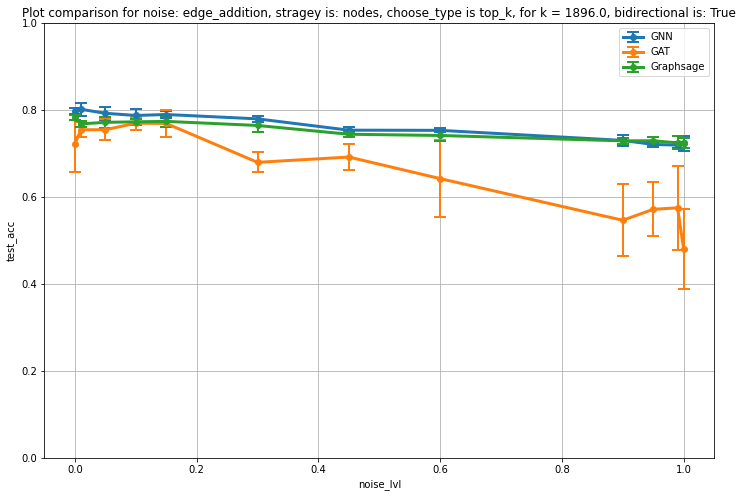

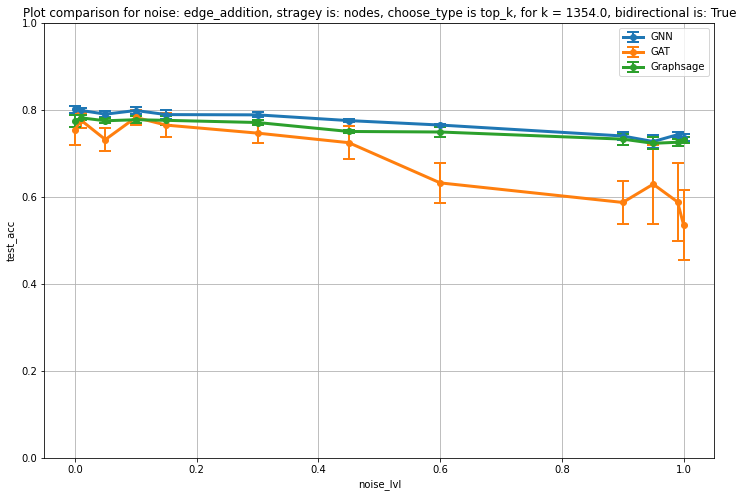

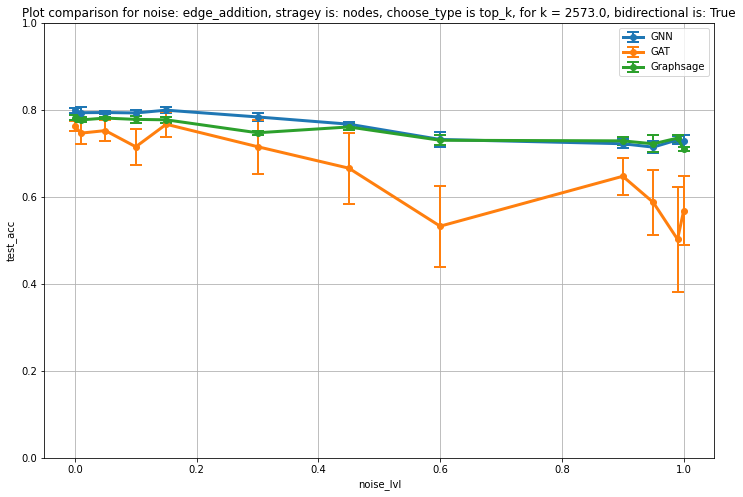

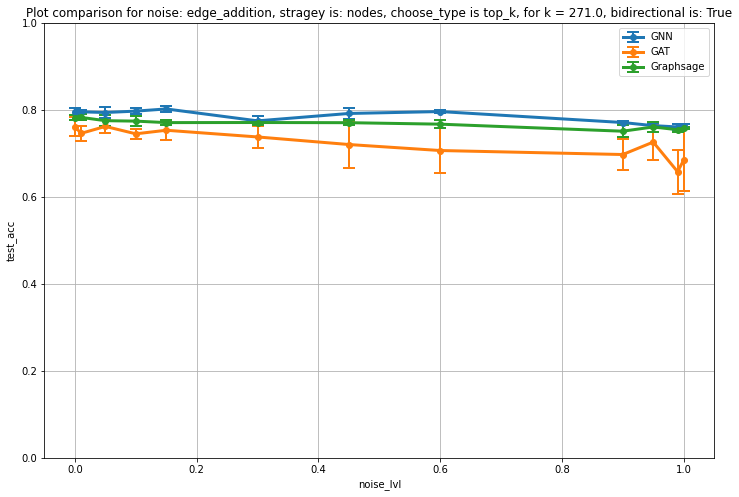

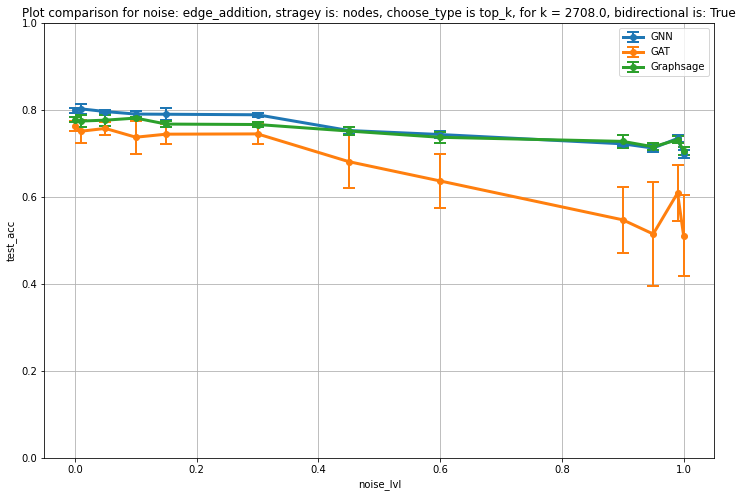

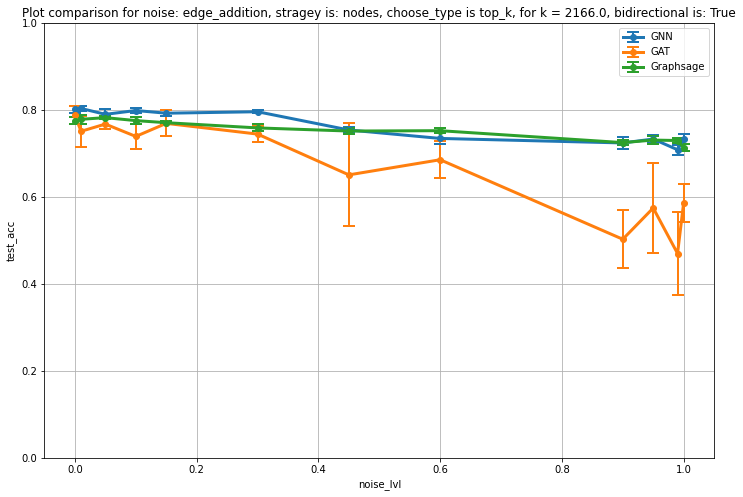

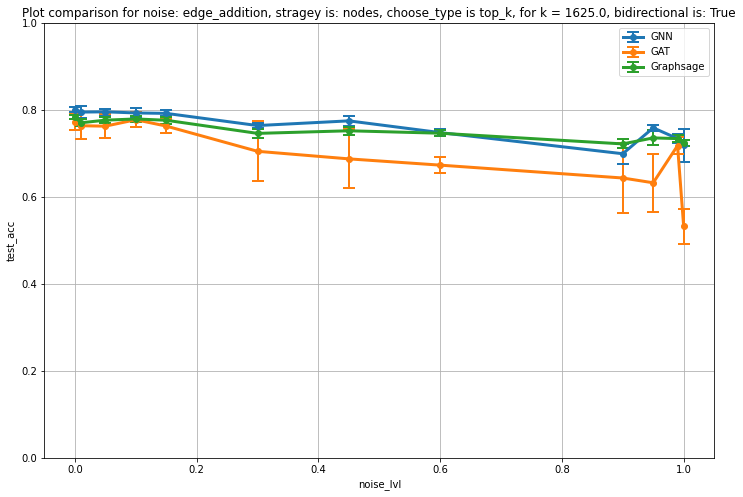

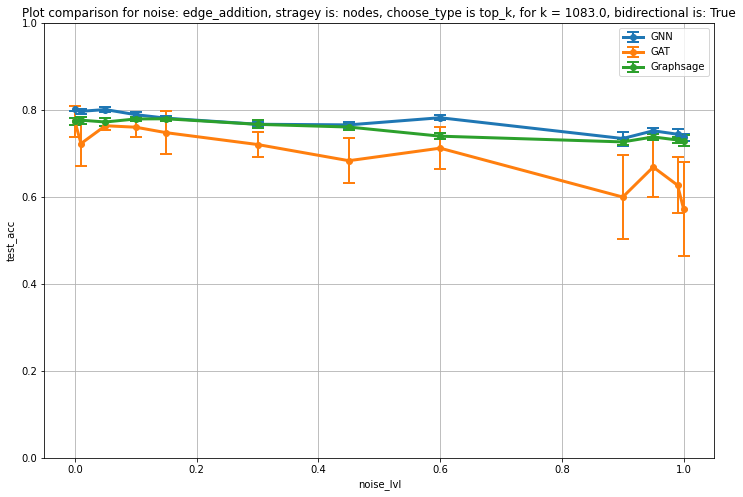

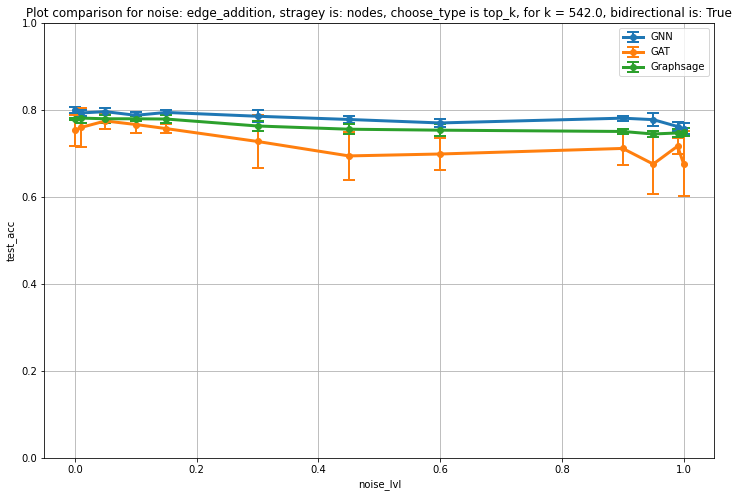

In [67]:
plot_comparison(data, 'edge_addition', 'nodes', 'top_k', k_nodes=list(k_nodes), bidirectional=False)
plot_comparison(data, 'edge_addition', 'nodes', 'top_k', k_nodes=list(k_nodes), bidirectional=True)

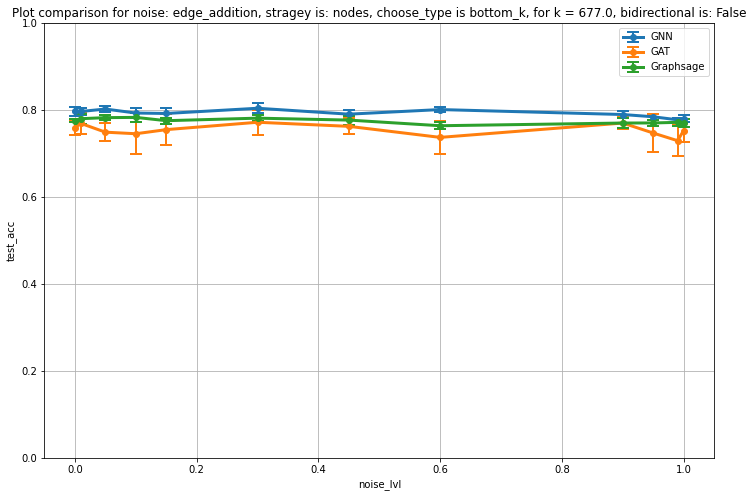

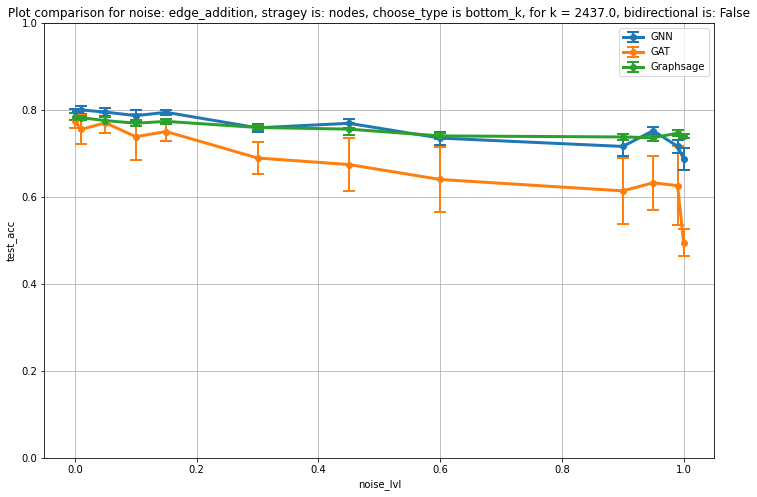

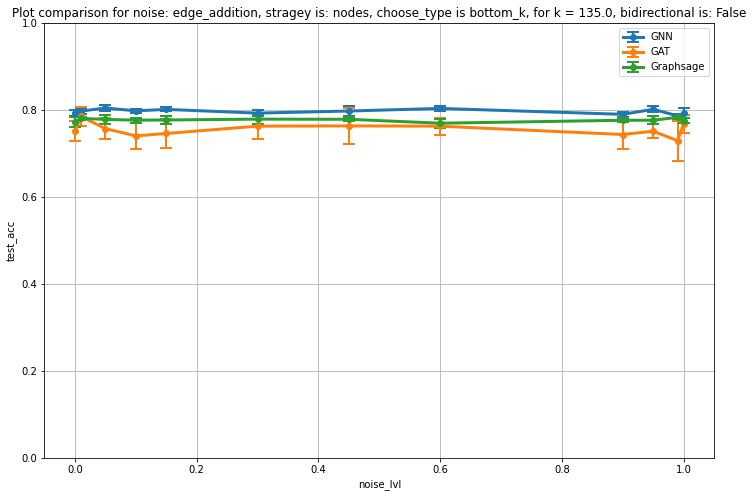

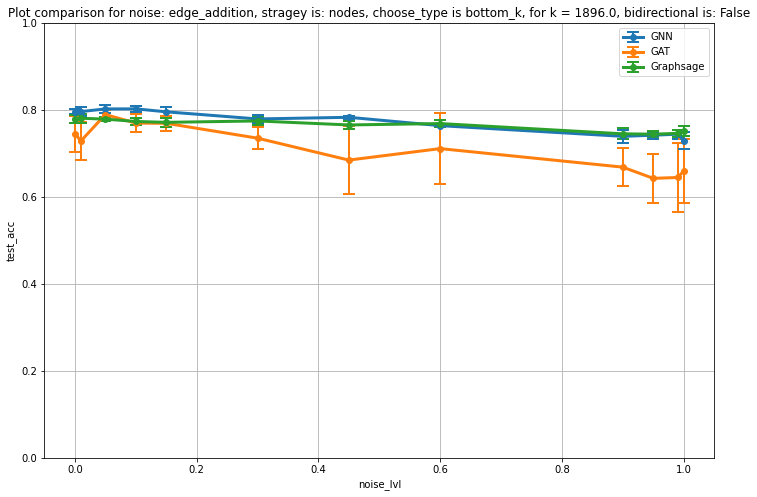

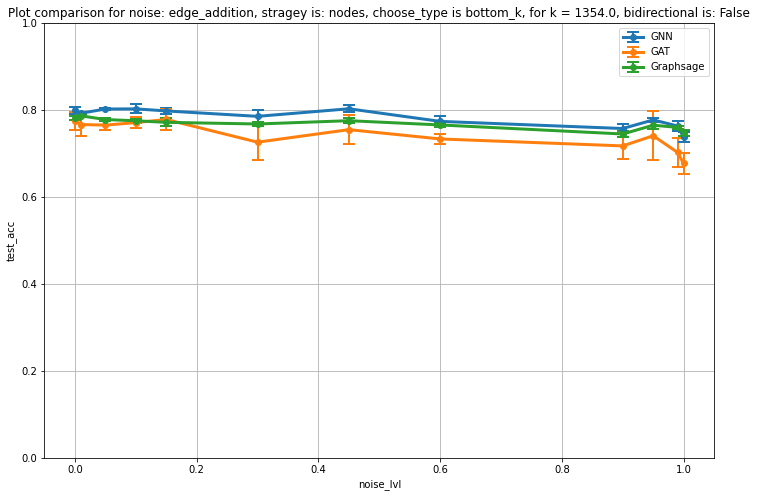

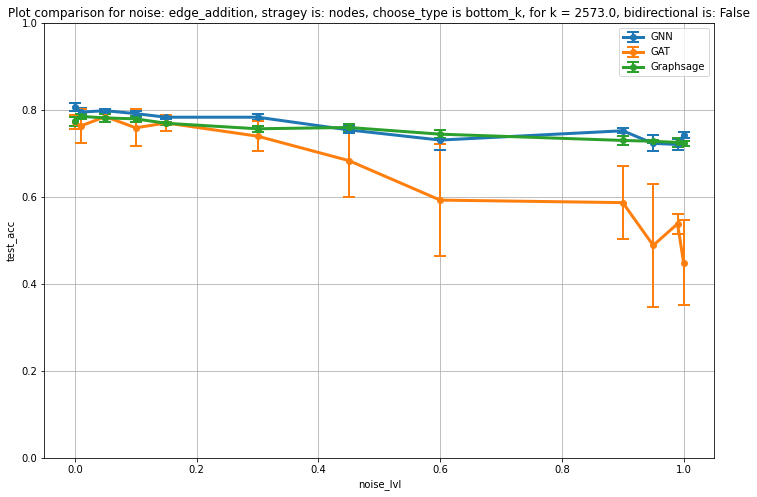

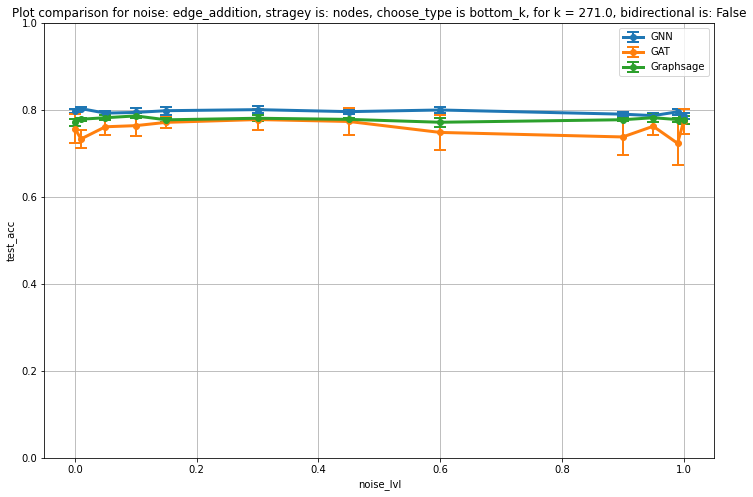

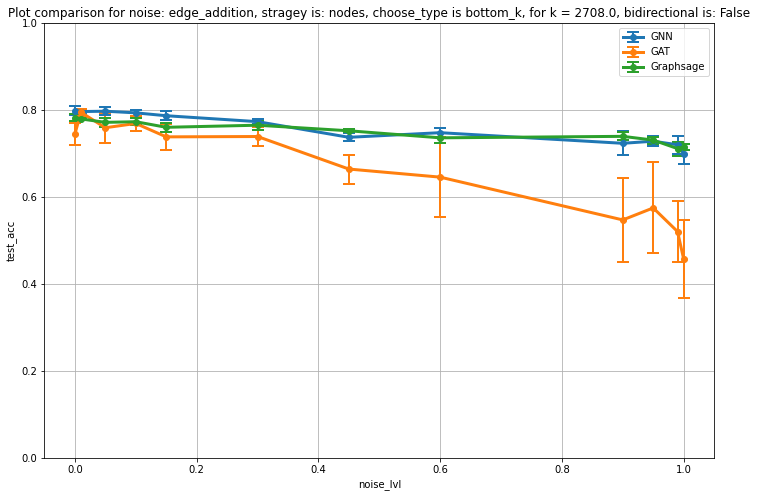

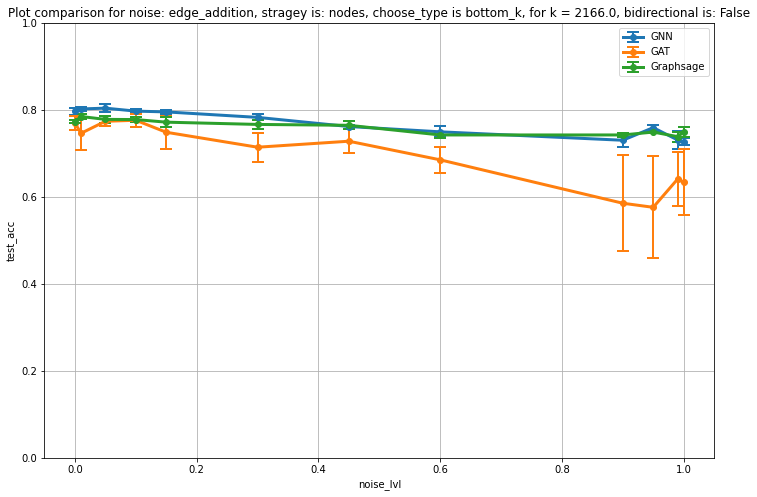

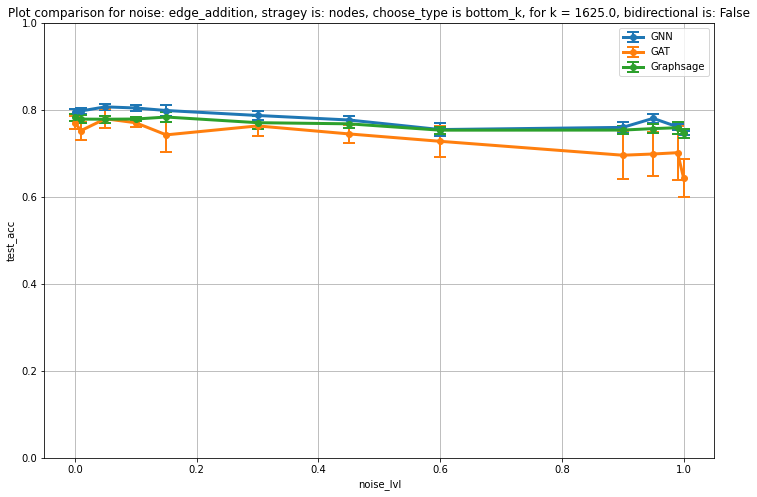

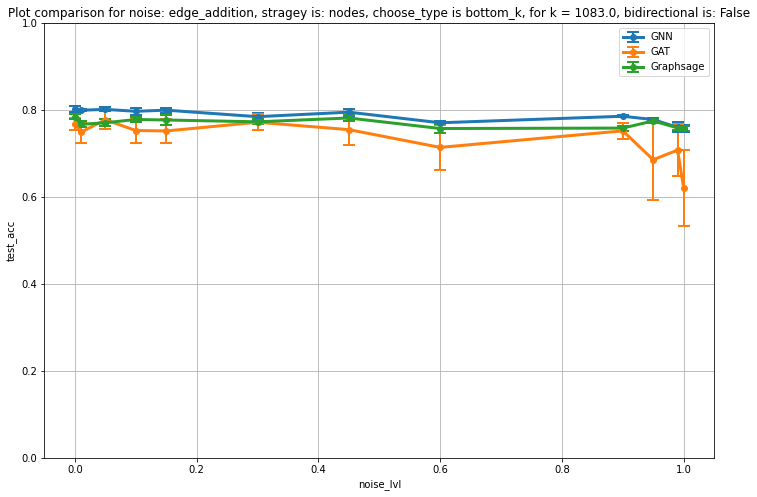

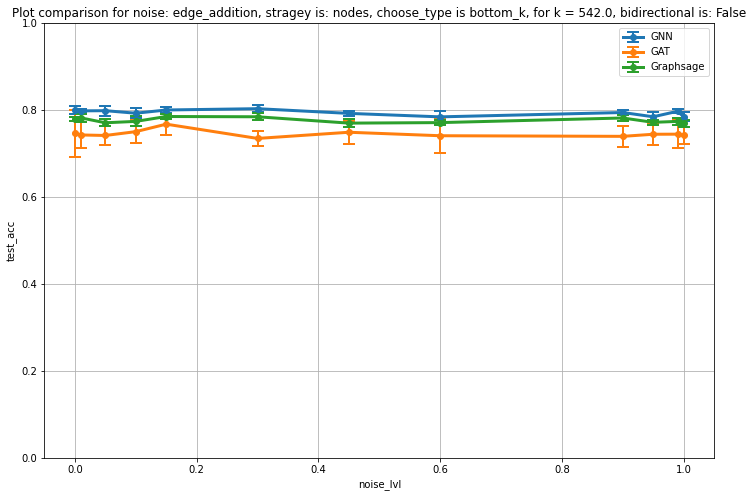

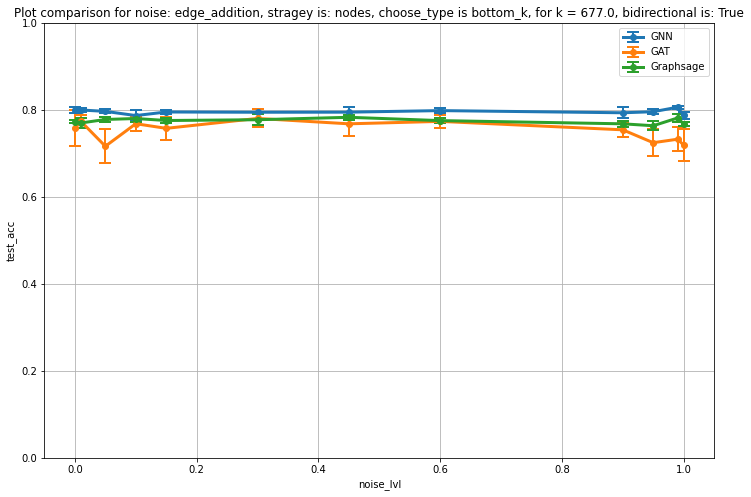

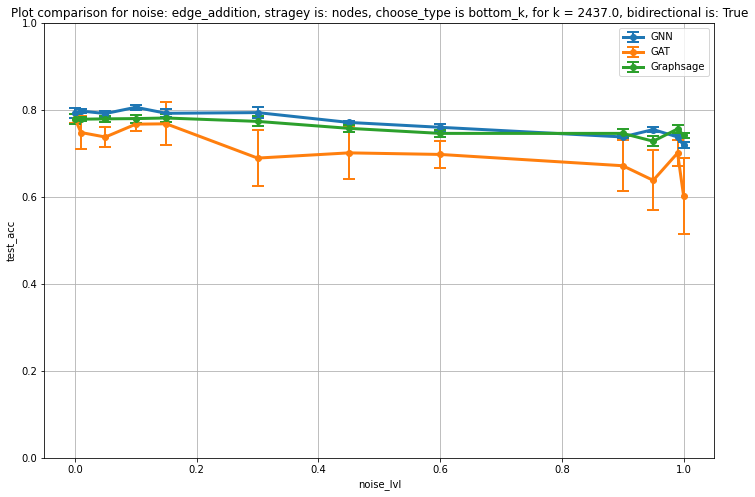

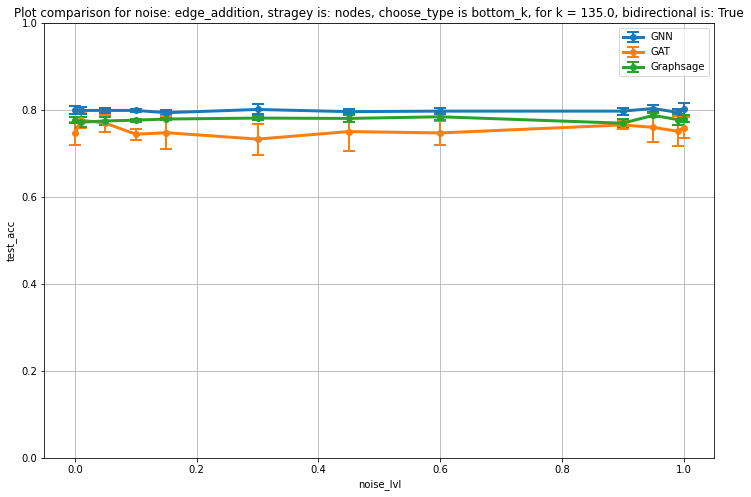

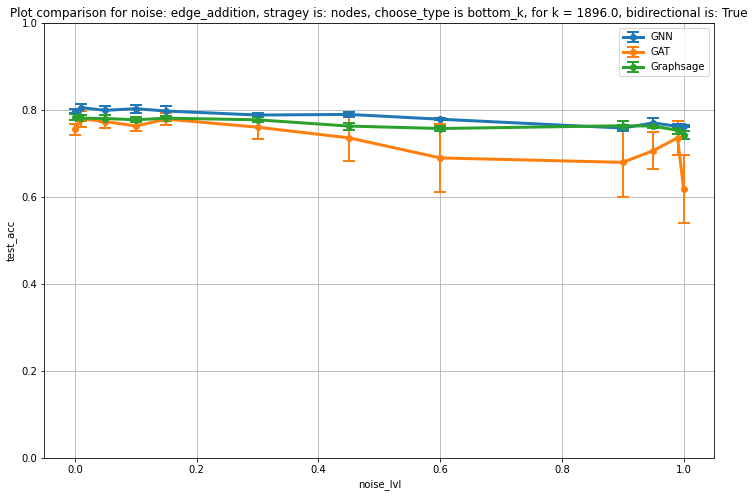

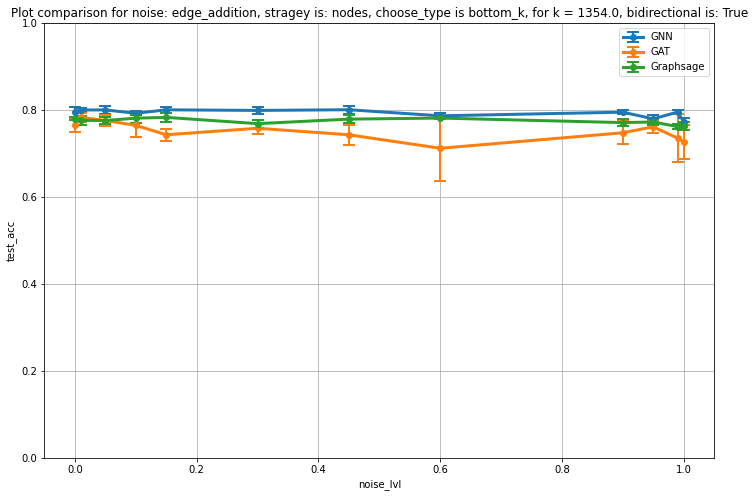

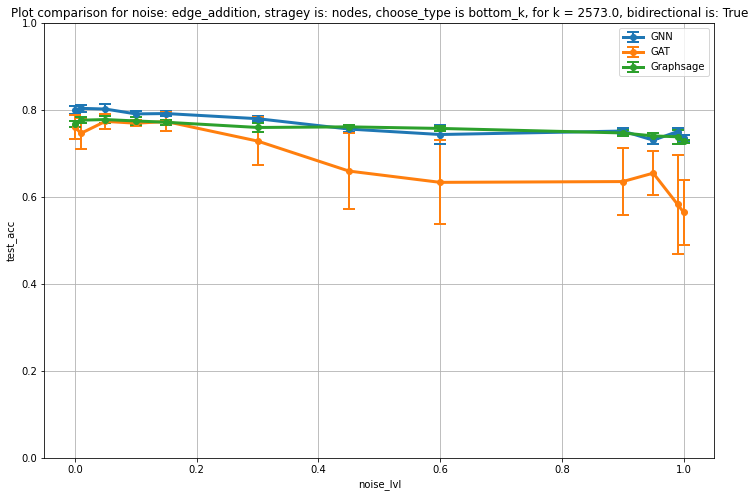

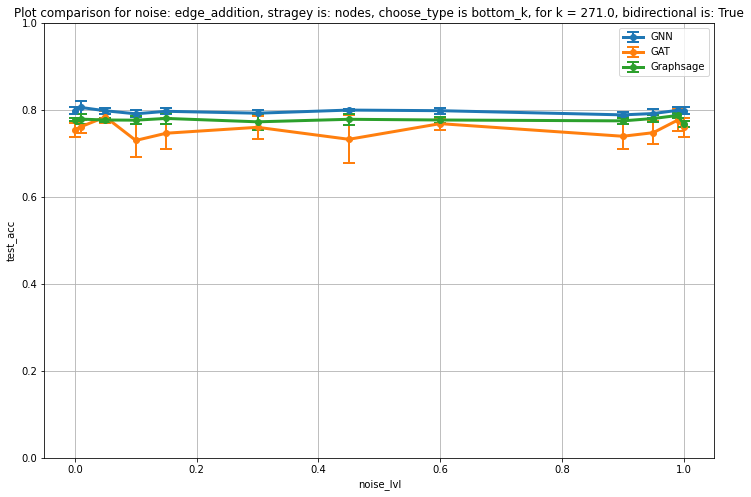

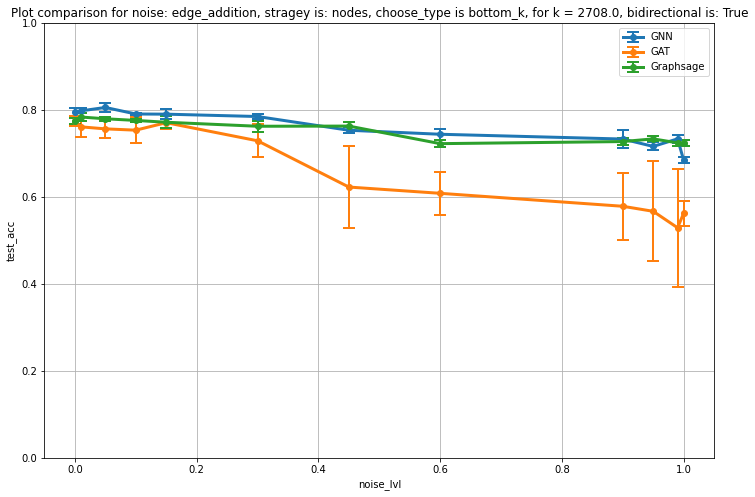

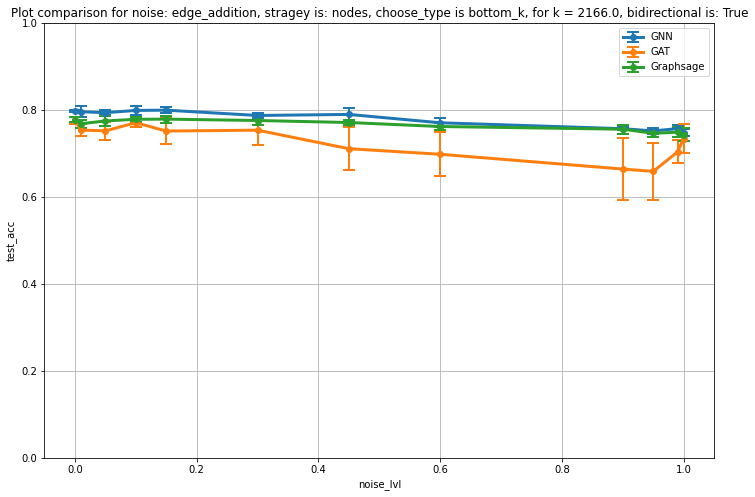

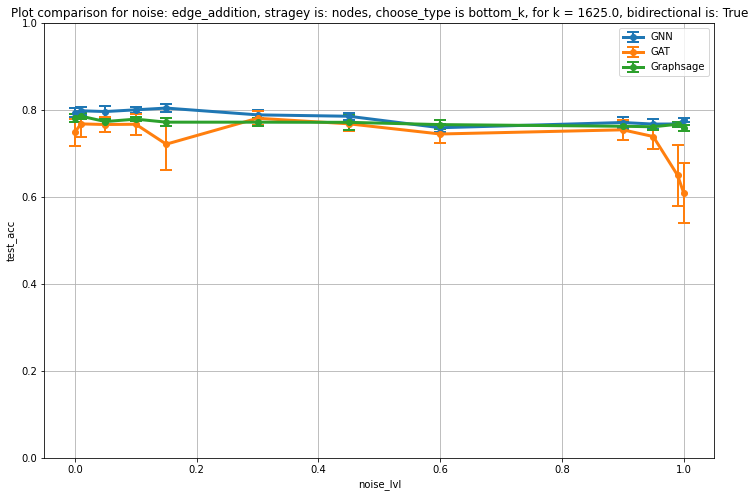

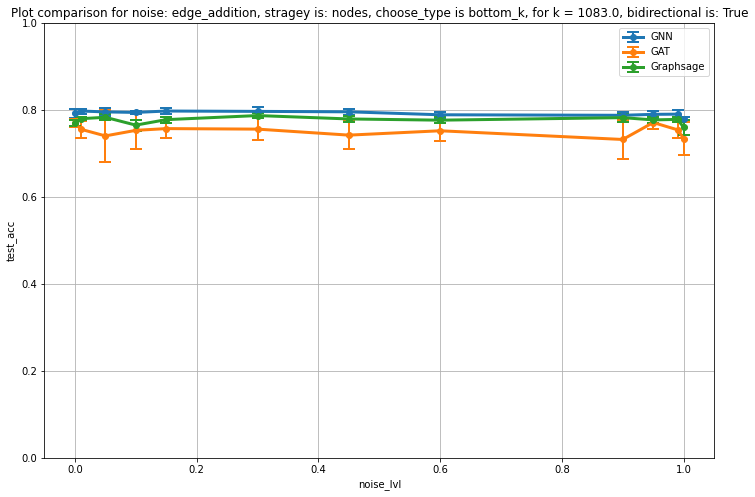

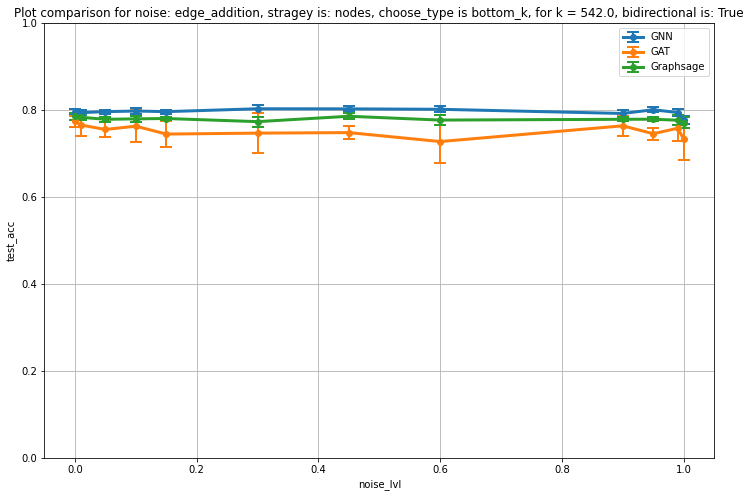

In [68]:
plot_comparison(data, 'edge_addition', 'nodes', 'bottom_k', k_nodes=list(k_nodes), bidirectional=False)
plot_comparison(data, 'edge_addition', 'nodes', 'bottom_k', k_nodes=list(k_nodes), bidirectional=True)